In [1]:
%cd ..
%load_ext autoreload

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code


In [2]:
import enum
import seaborn as sns
from data_handling.Data_Processor import DataProcessor
from data_handling.Data_Reader import DataReader
import constants
import os
from statistics_methods.Statistics import StatisticsWrapper
from statistics_methods.plots import PlotsManager
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster
import wandb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error as MSE
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
from scipy import stats
from scipy.stats import linregress
import copy


Constants

In [3]:
chosen_rois_dict = constants.SUB_CORTEX_DICT
params_to_work_with = constants.ALL_PARAMS
slopes = constants.SLOPES

Load the data and proccess it

In [4]:
def load_data(data_path, slopes=None, outliers=[]):
    subjects_raw_data = DataProcessor(data_path, chosen_rois_dict, chosen_rois_dict).get_data_proccessed()
    analyzed_data = StatisticsWrapper.calc_median_per_subject_per_parameter_per_ROI(subjects_raw_data, params_to_work_with)
    chosen_data = StatisticsWrapper.chose_relevant_data(analyzed_data, chosen_rois_dict, params_to_work_with, params_to_work_with)

    chosen_data = chosen_data[~chosen_data.subjects.isin(outliers)]
    if slopes:
        chosen_data.groupby('subjects').apply(normalize_params, slopes)

    group_a_name, group_b_name, col_divider, threshold = constants.YOUNG, constants.OLD, 'Age', constants.AGE_THRESHOLD
    young_subjects, old_subjects = StatisticsWrapper.seperate_data_to_two_groups(chosen_data, col_divider, threshold)

    return chosen_data, young_subjects, old_subjects

def normalize_params(data, params):
    data_copy = copy.deepcopy(data)

    for param in params:
        data_copy[param] = stats.zscore(data_copy[param], nan_policy='omit')

    return data    

In [8]:
outliers = ['H047_DC', 'H039_JH']
chosen_data_raw, young_subjects_raw, old_subjects_raw = load_data(constants.PATH_TO_SUB_CORTEX_all_params_raw, outliers=outliers)
chosen_data_z_score, young_subjects_z_score, old_subjects_z_score = load_data(constants.PATH_TO_SUB_CORTEX_all_params_z_score, outliers=outliers)

chosen_data_z_score.subjects.nunique()

34

In [9]:
DataProcessor.outliers_counter(chosen_data_raw, params_to_work_with, chosen_rois_dict)

outliers counter: {'H052_OF': 2, 'H046_NB': 1, 'H051_YK': 1, 'H026_LY': 1, 'H023_IN': 1, 'H032_JD': 1, 'H054_AE': 1, 'H036_EV': 1, 'H020_RR': 1, 'H033_MB': 1, 'H034_HB': 1}


## Raw data analysis 

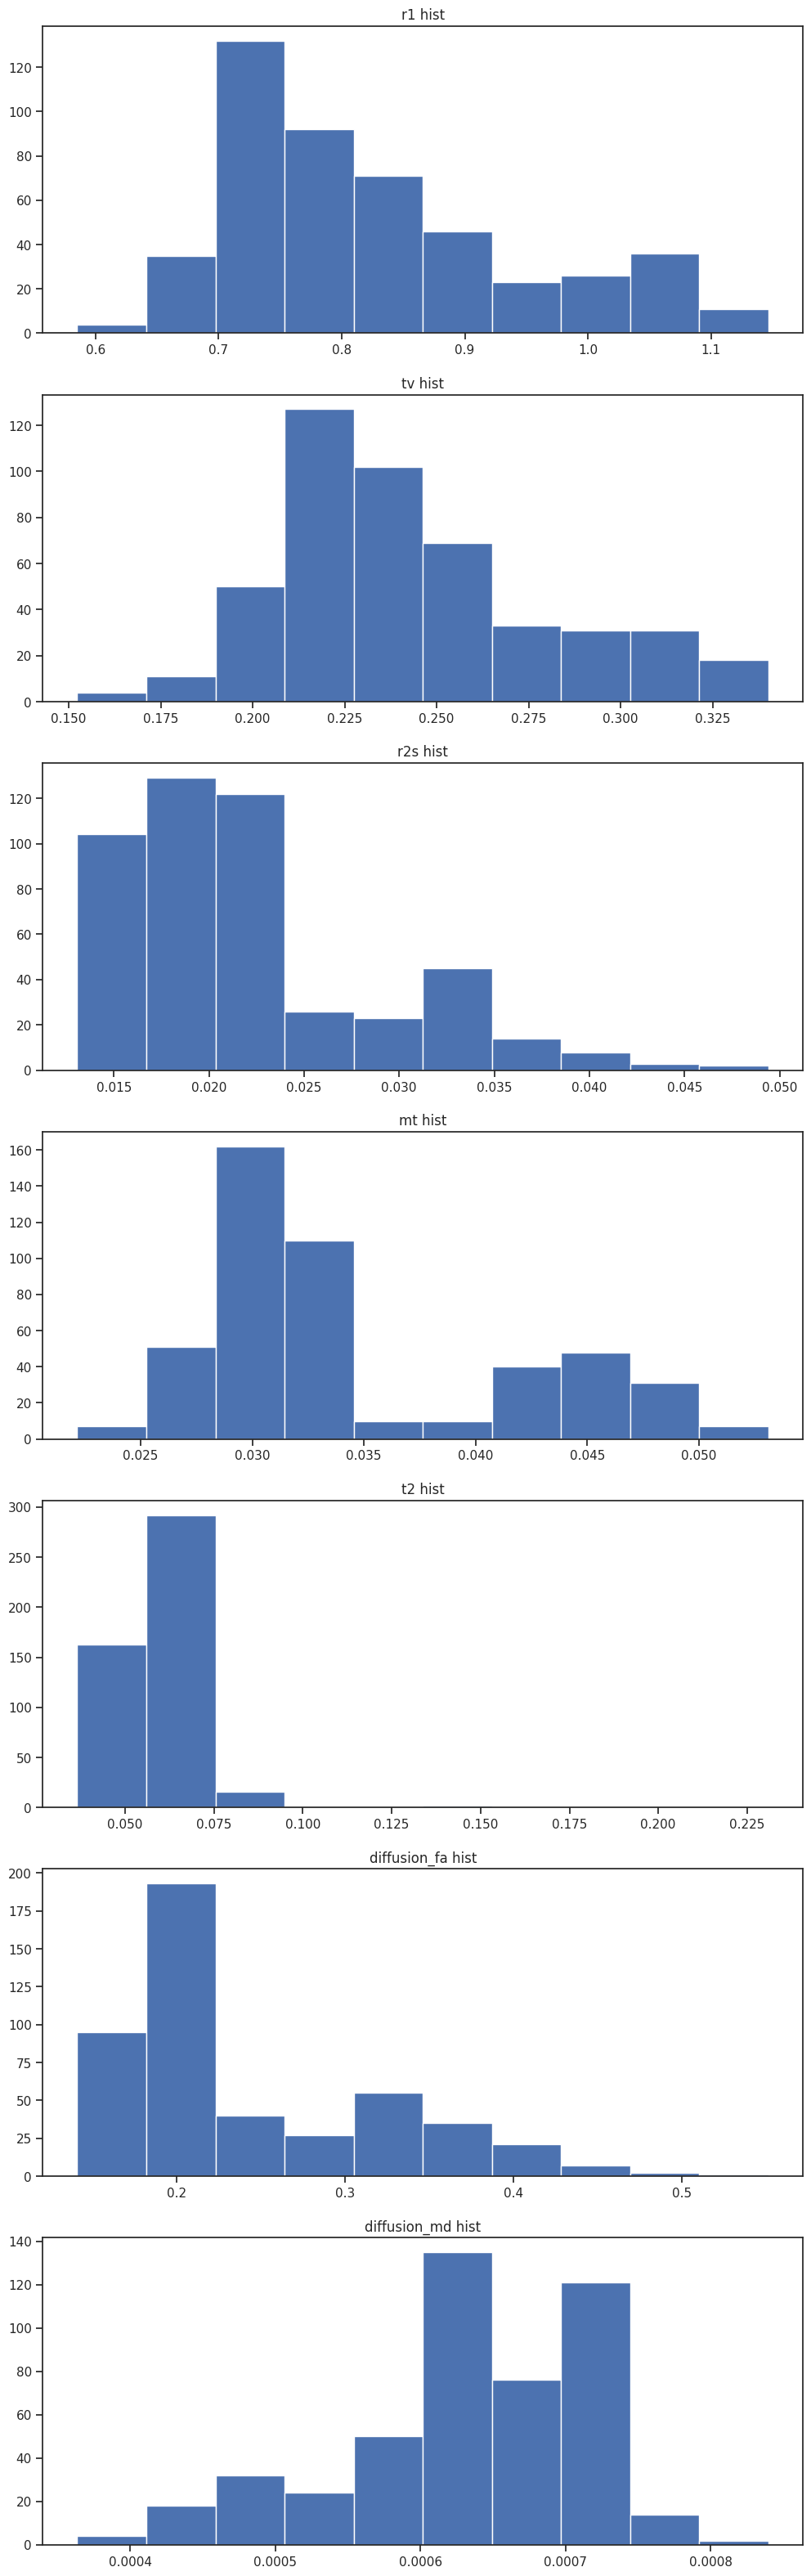

In [12]:
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(12, 40))

for i, param in  enumerate(params_to_work_with):
    ax[i].set_title(f'{param} hist')
    ax[i].hist(chosen_data_raw[param])

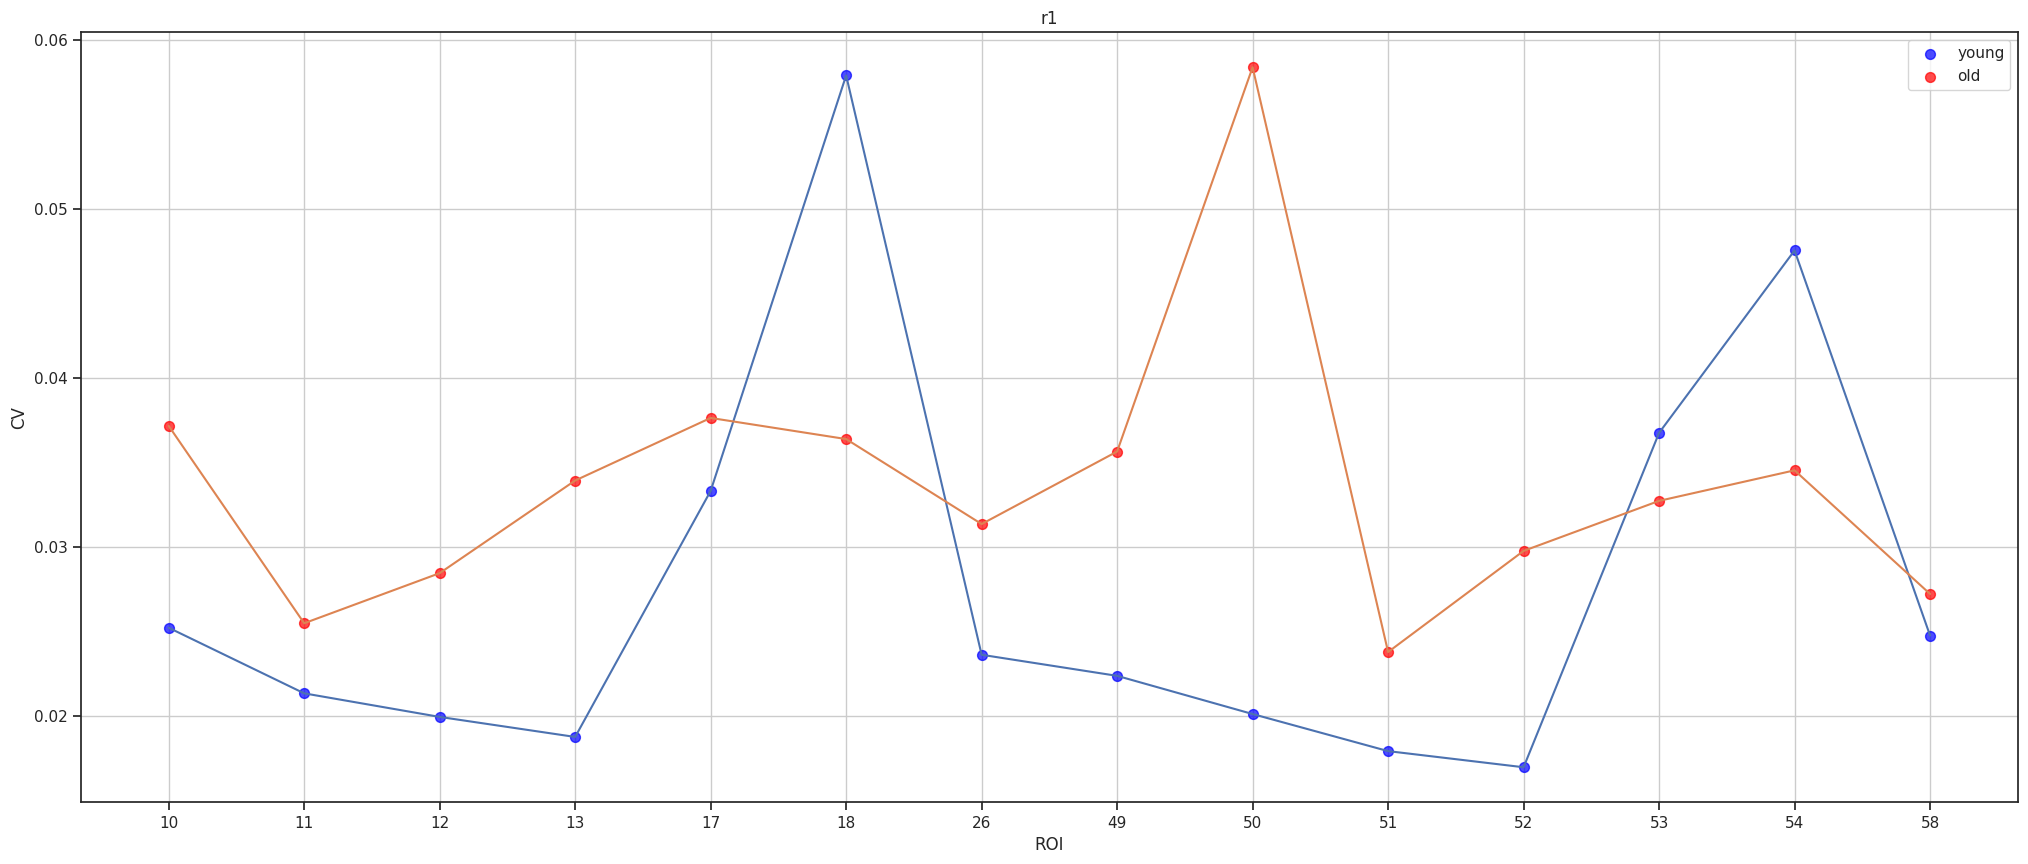

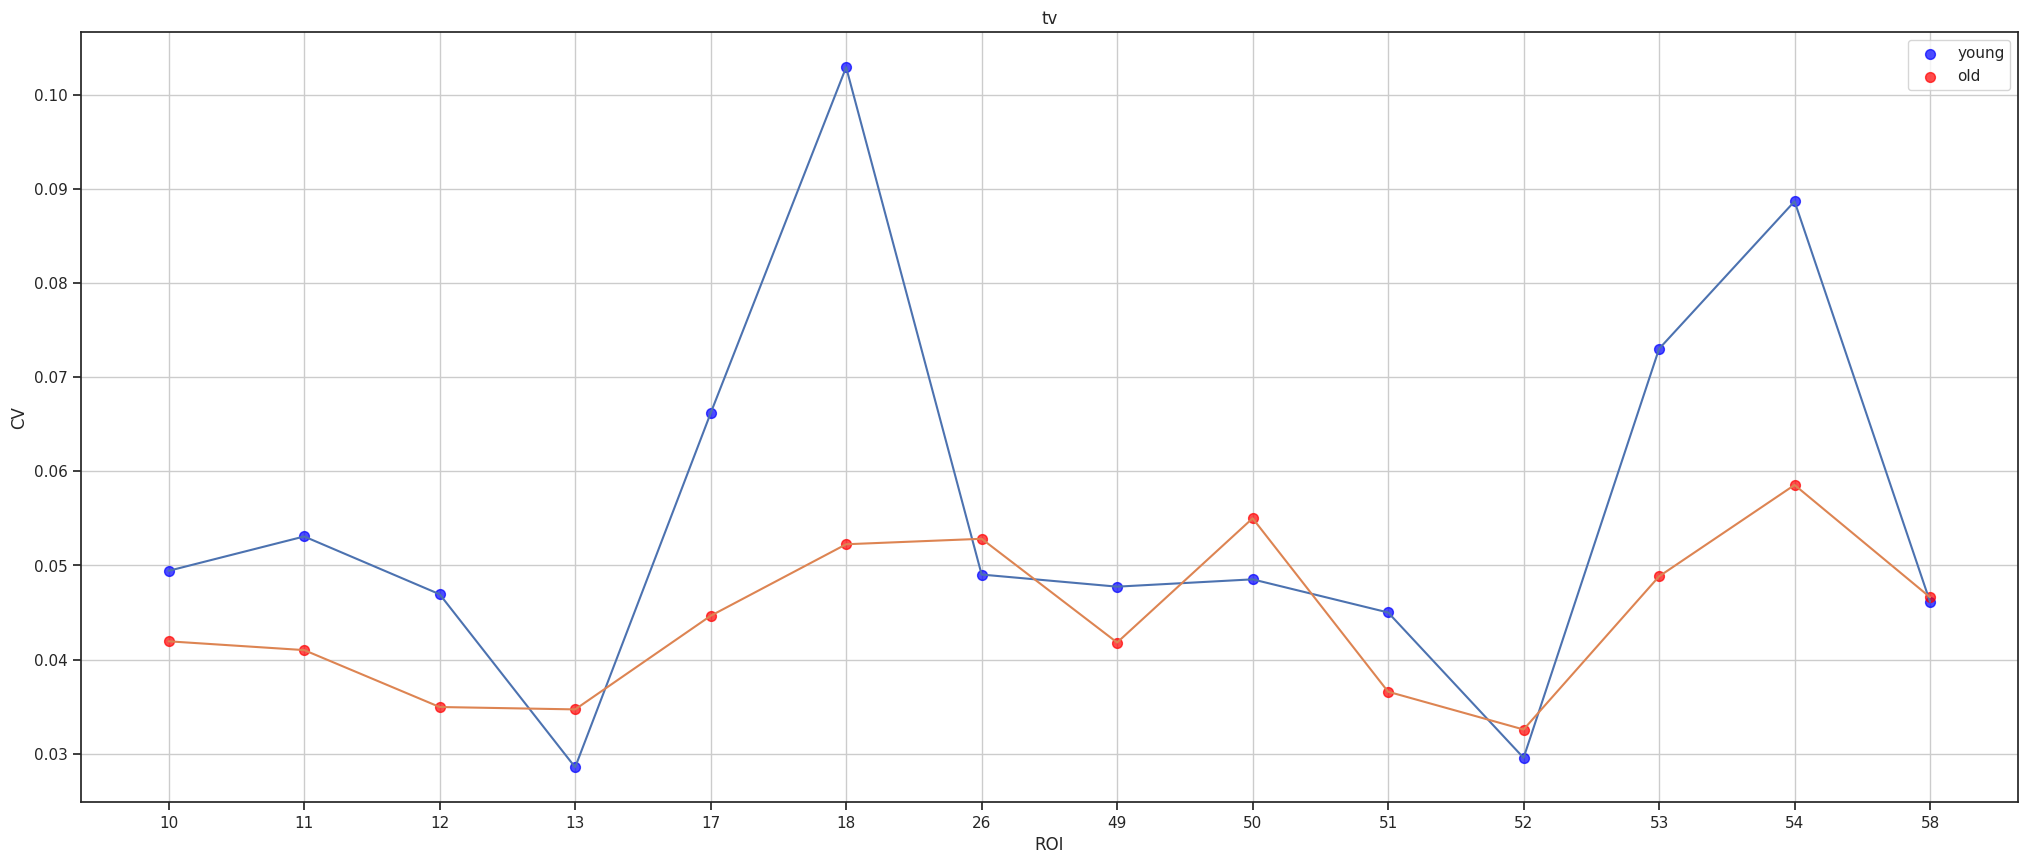

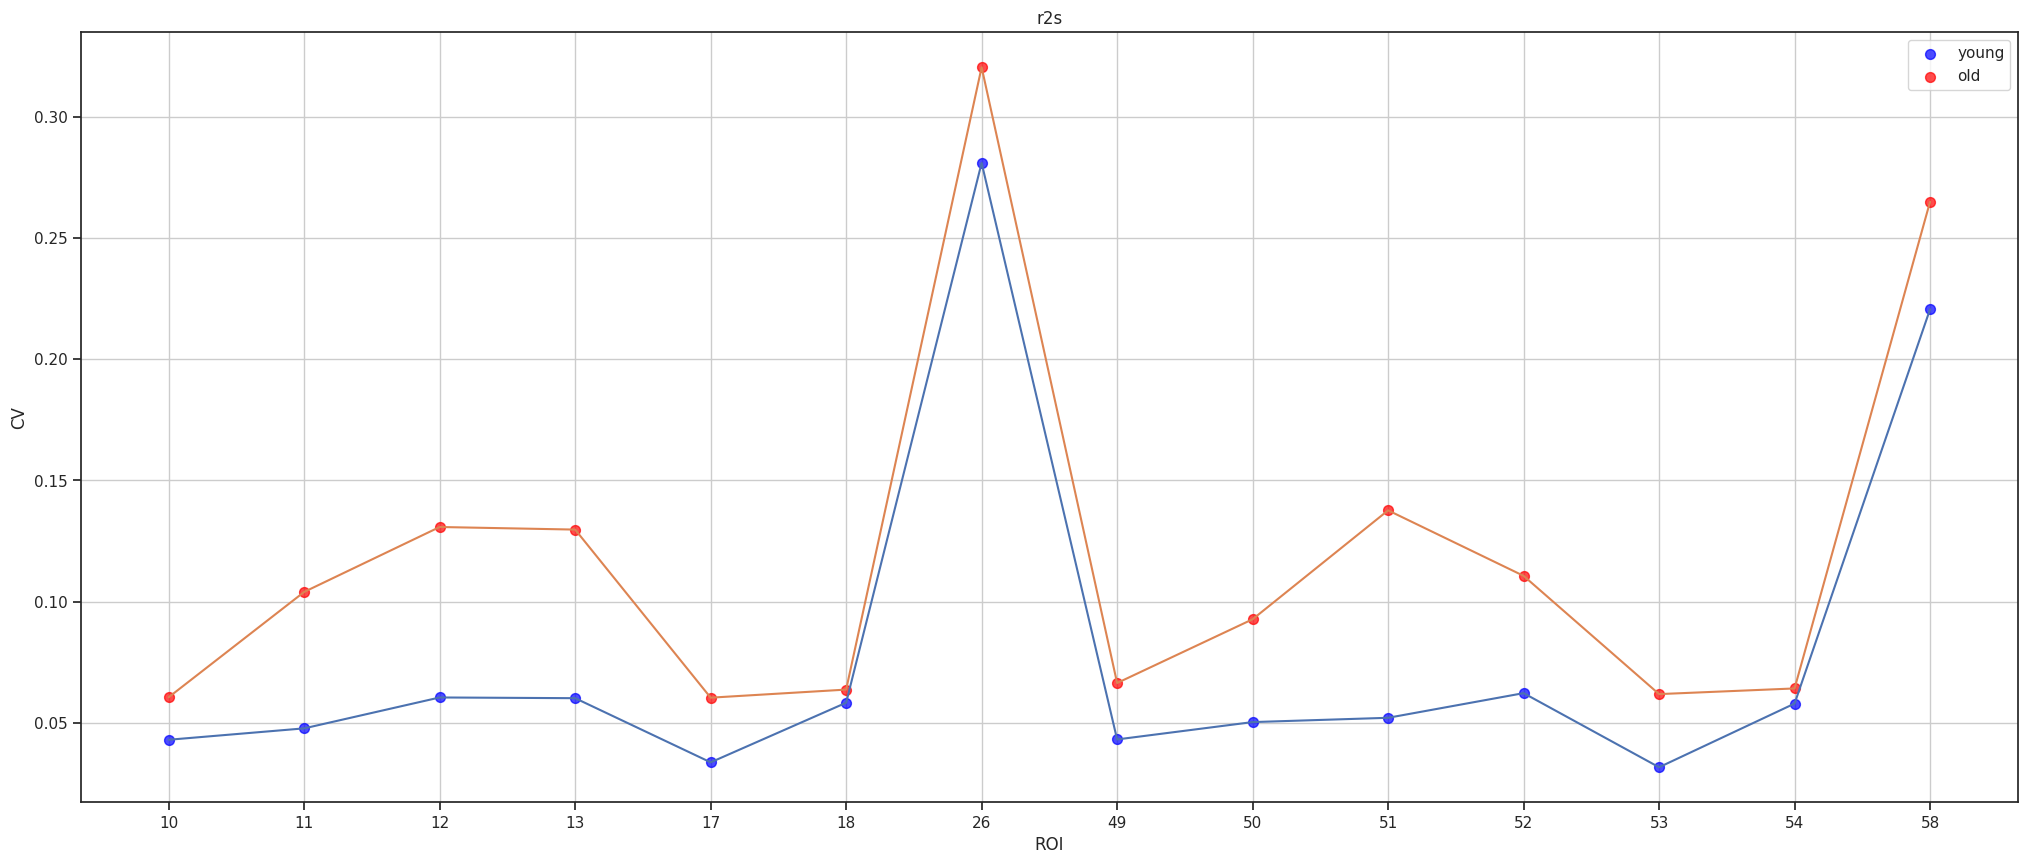

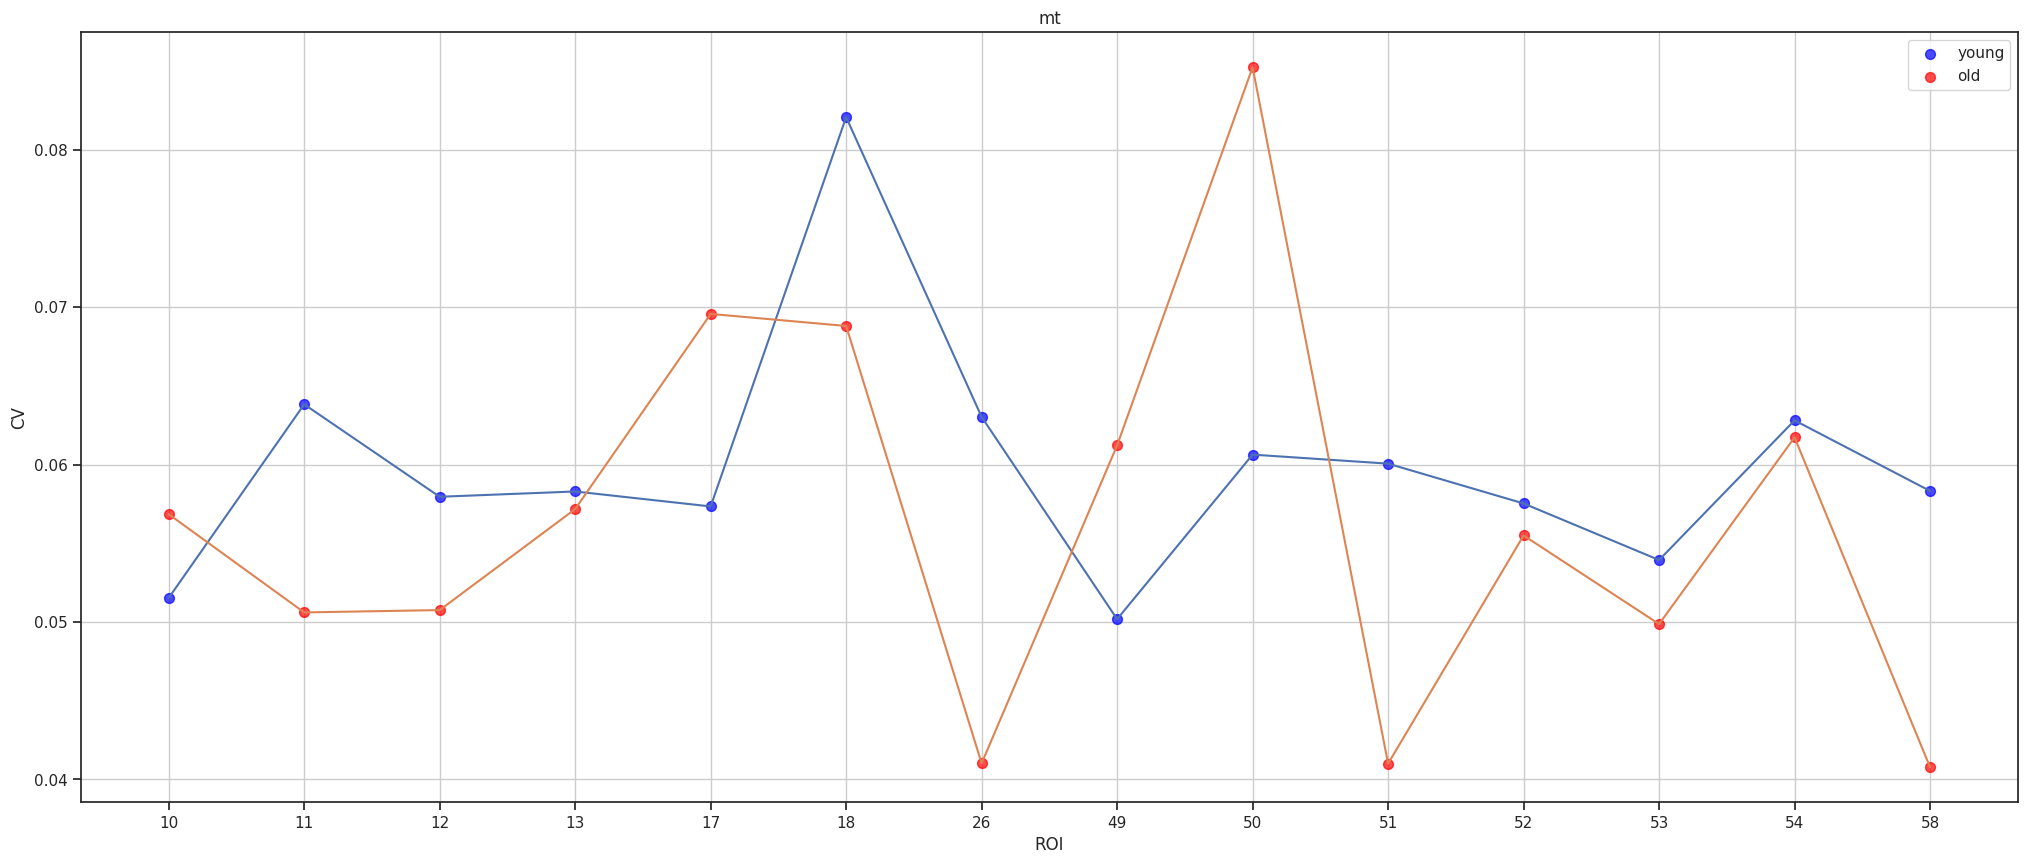

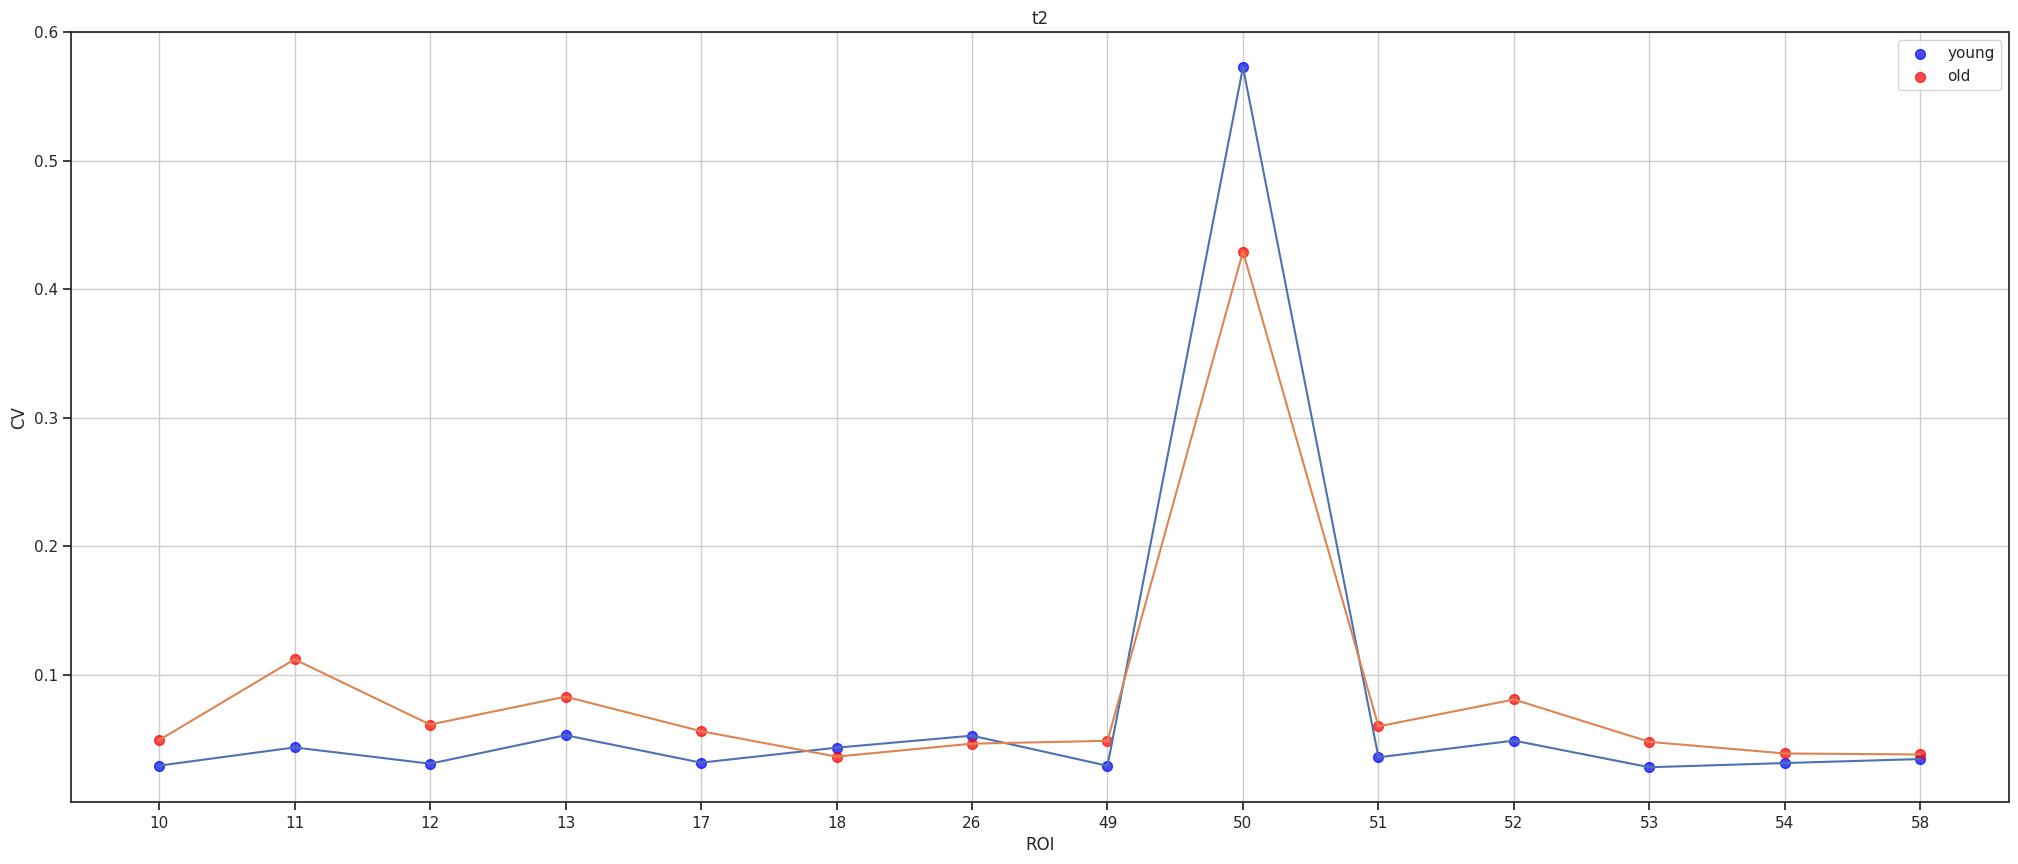

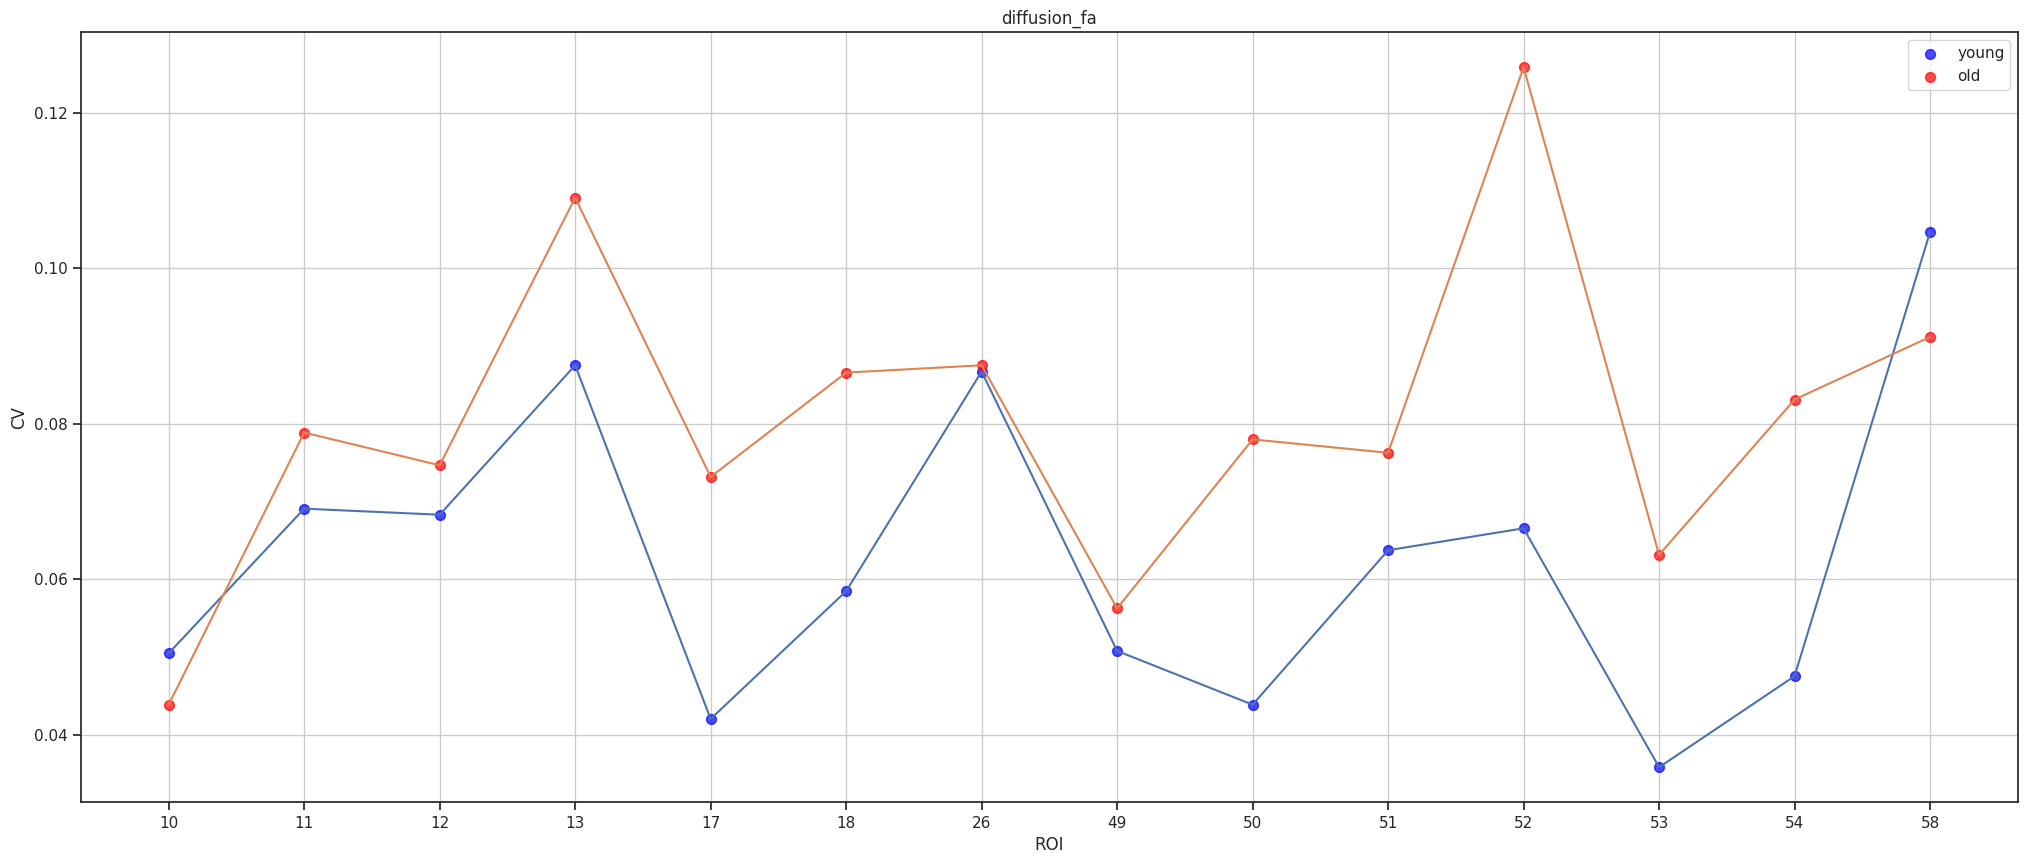

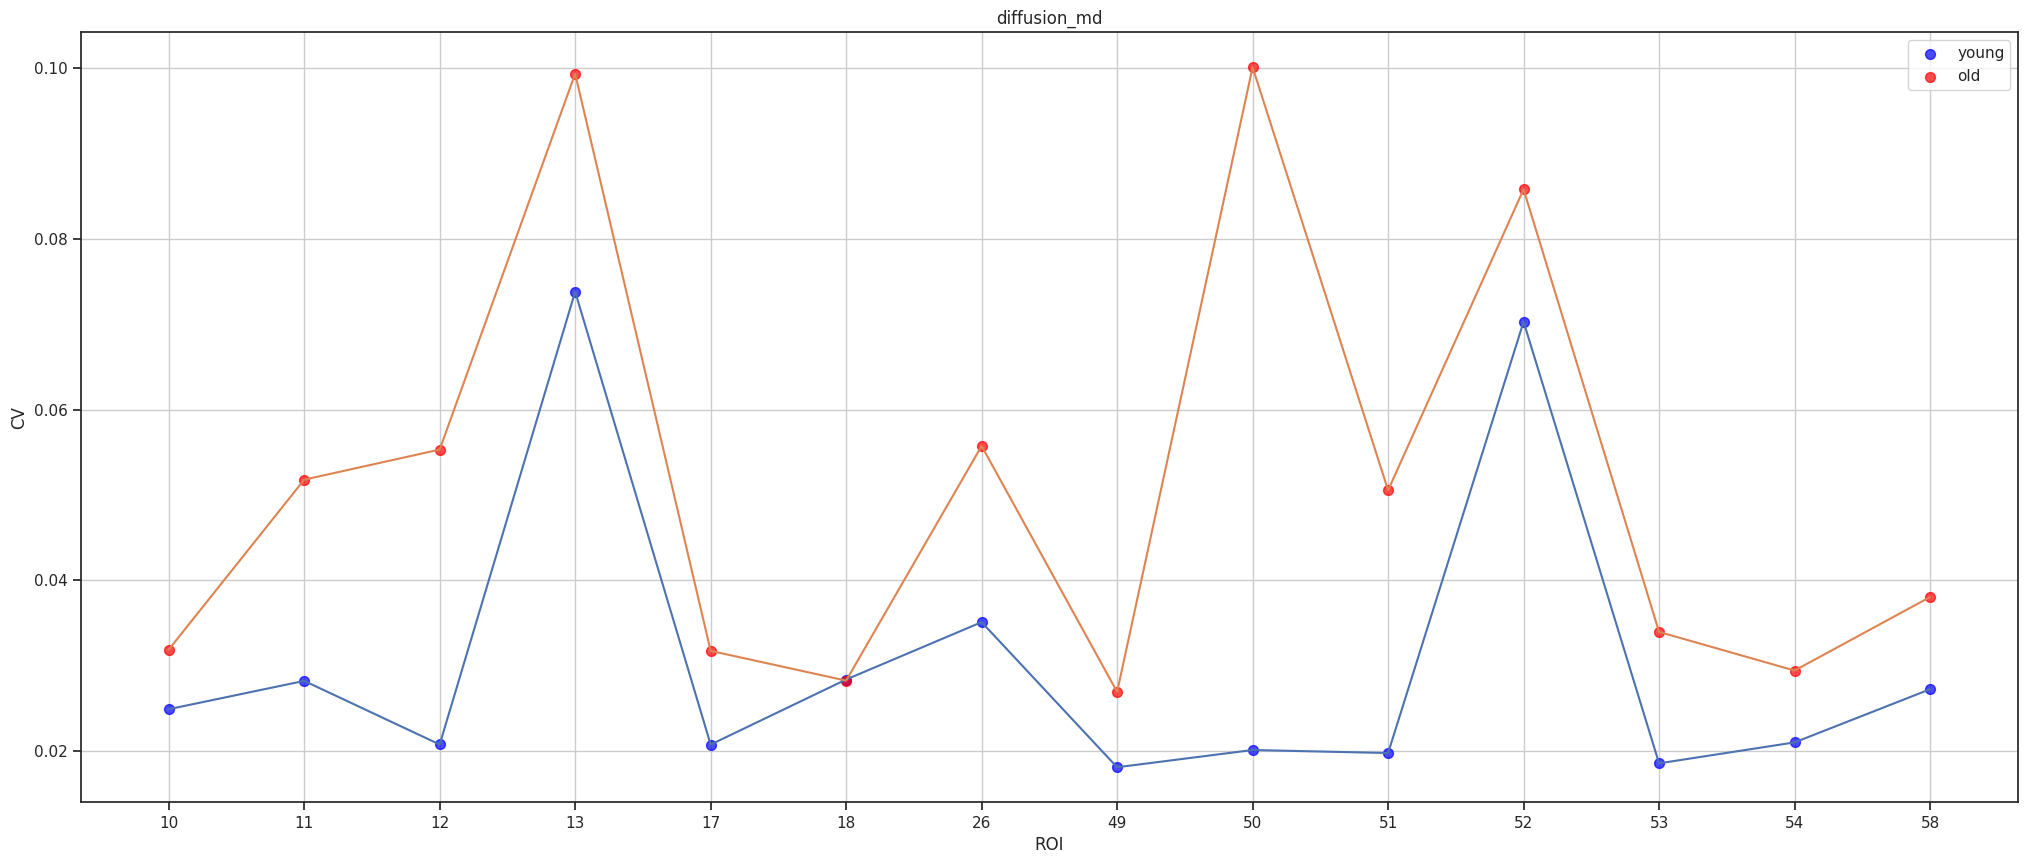

In [13]:
group_by_param = 'ROI'
x_axis = 'ROI'
data_groups = [(young_subjects_raw, 'blue', 'young'), (old_subjects_raw, 'red', 'old')]
StatisticsWrapper.calculate_cv_for_subjects(data_groups, group_by_param, params_to_work_with, x_axis, use_reg=False, fig_size=(25, 10), connect_scatter=True)

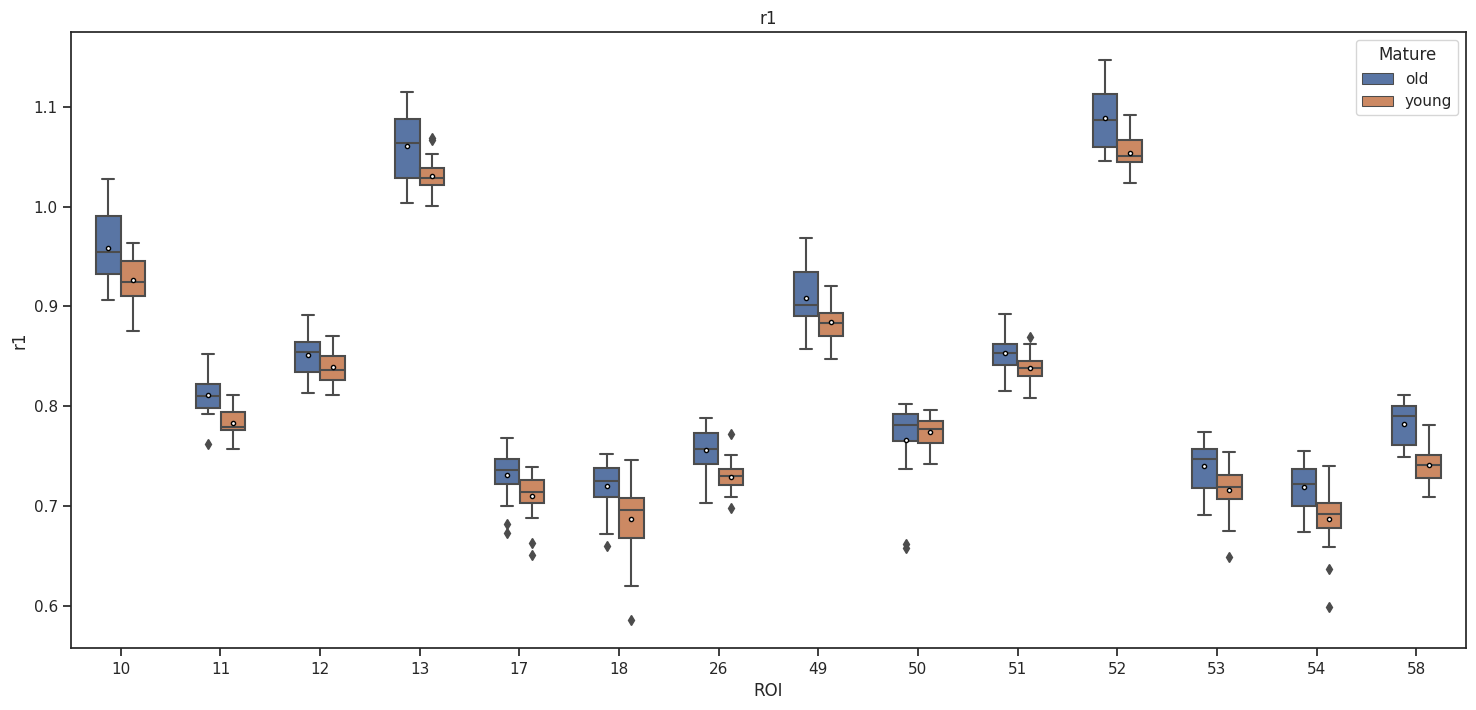

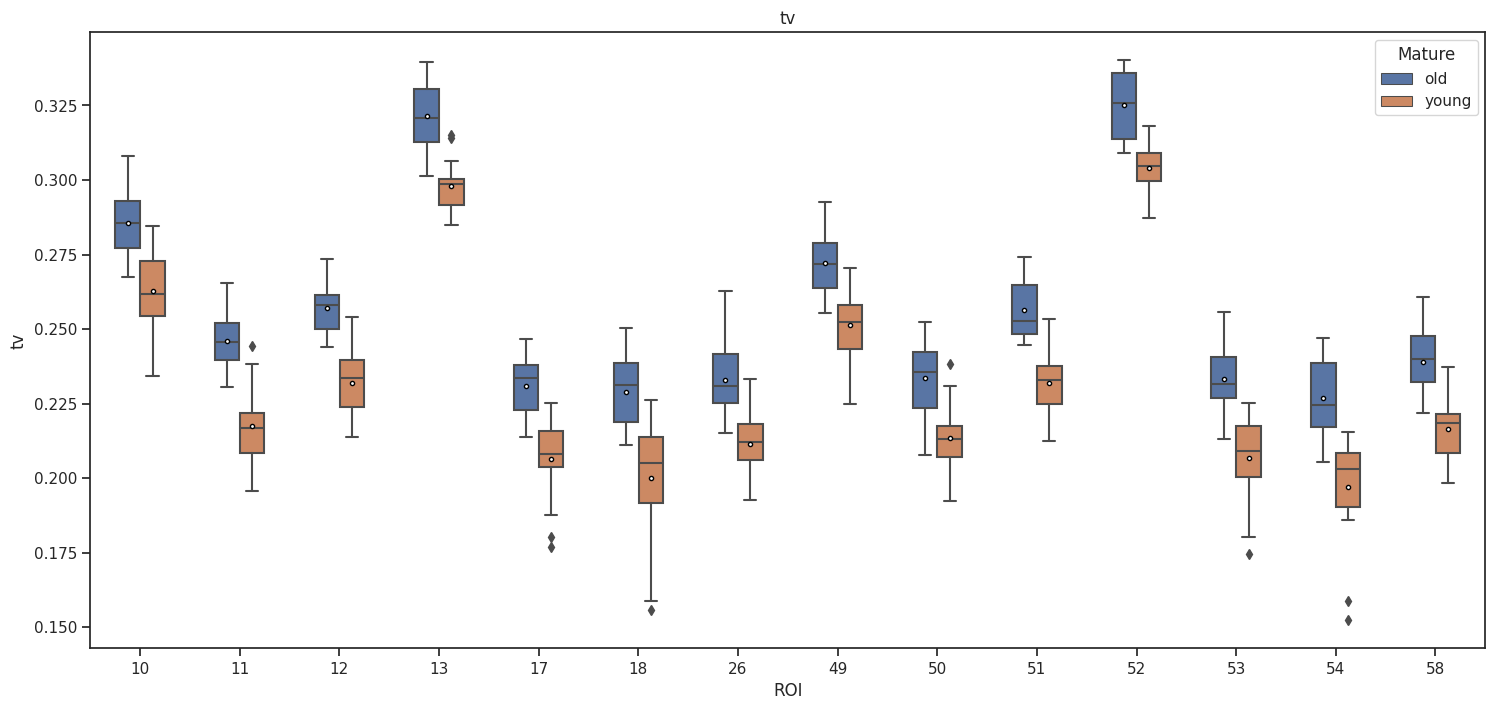

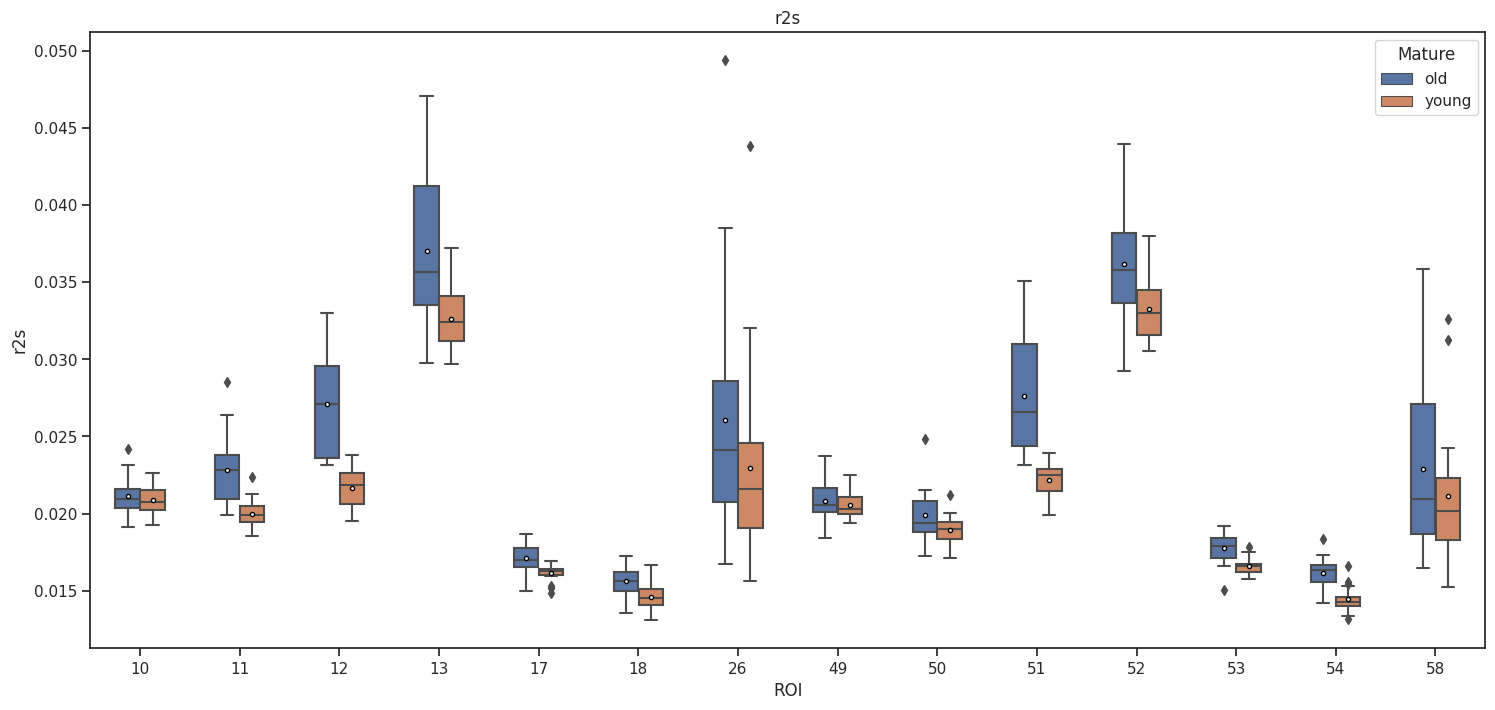

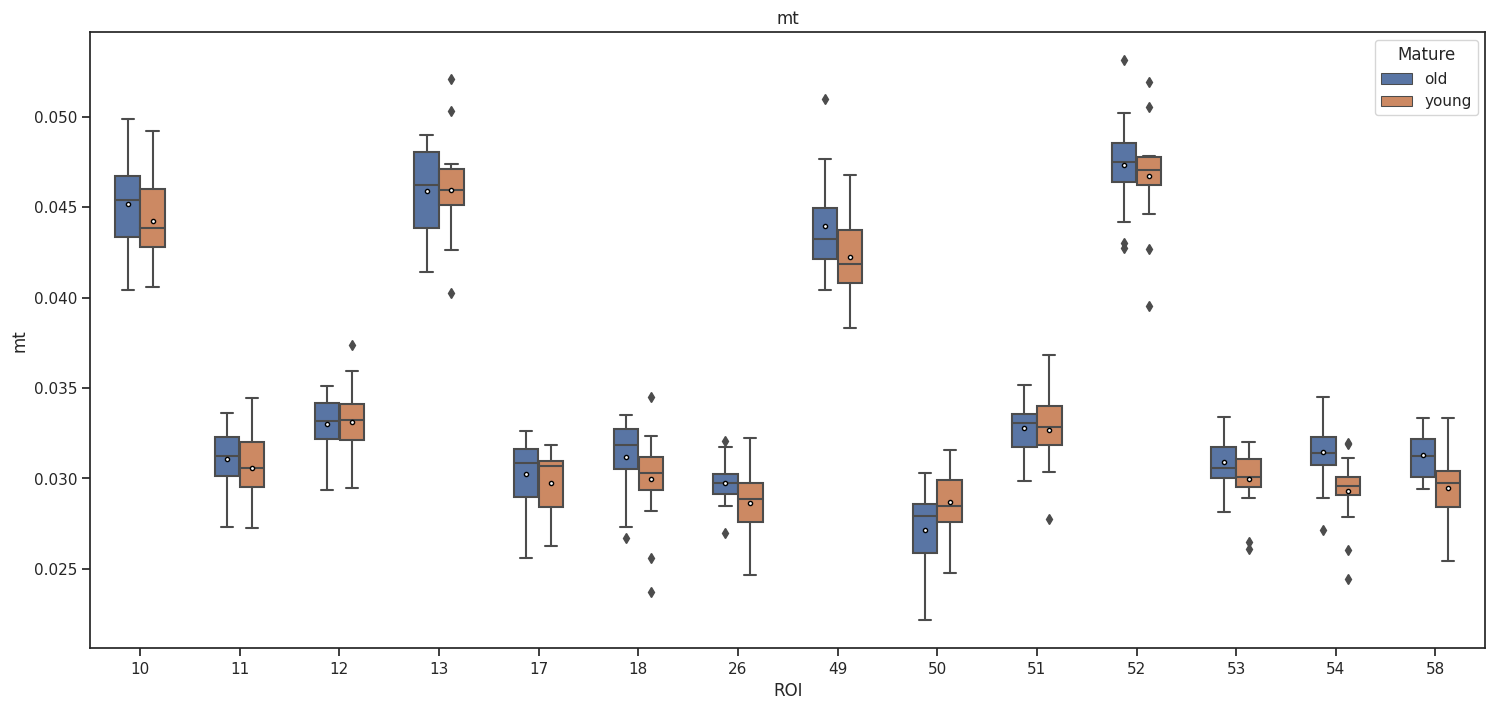

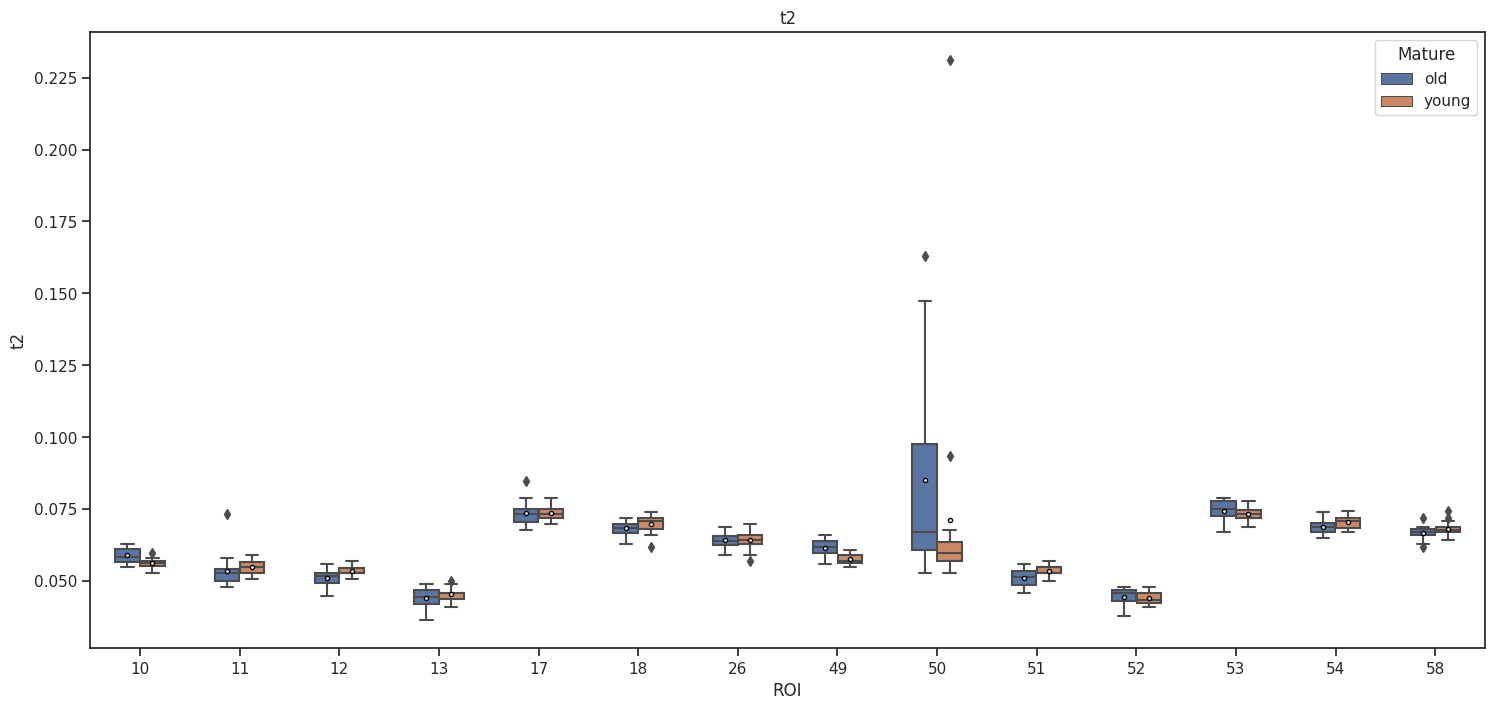

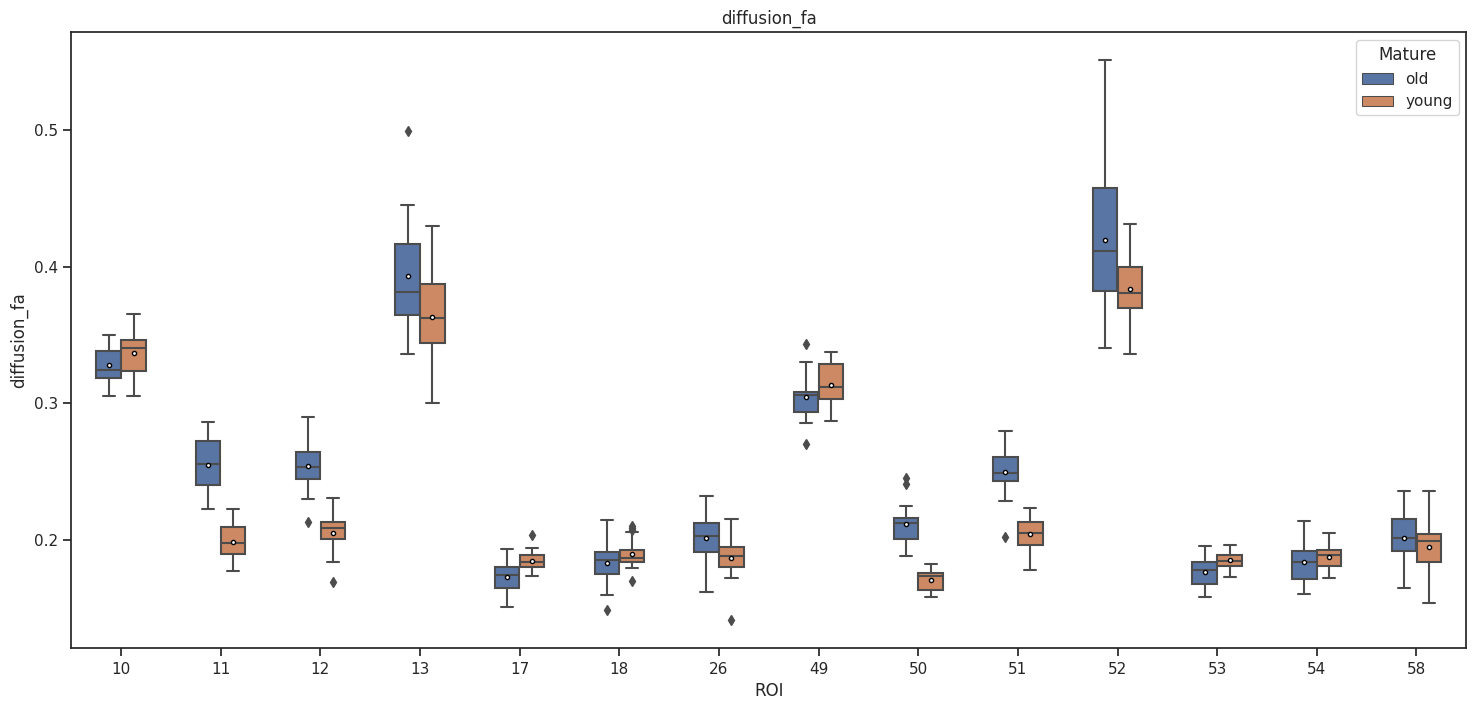

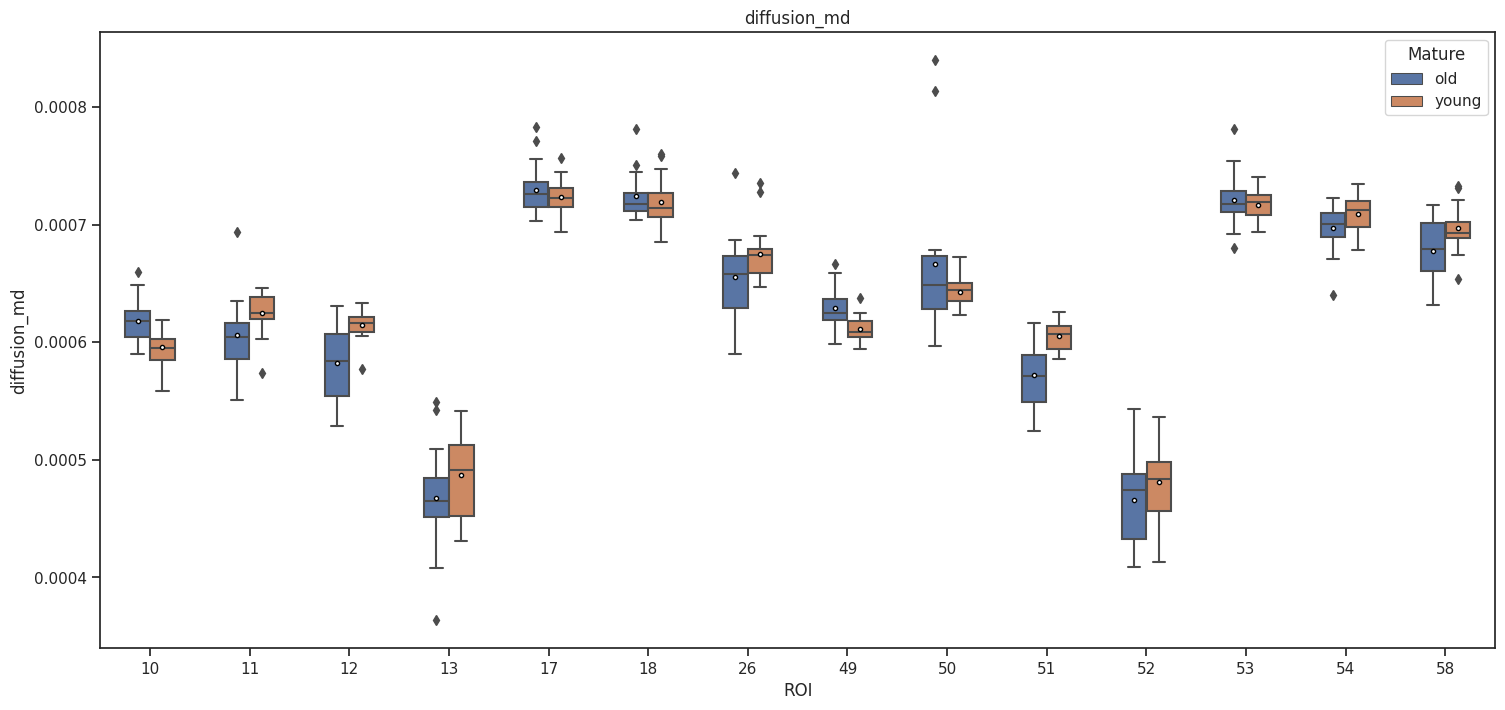

In [14]:
%autoreload 2
StatisticsWrapper.plot_data_per_param_per_roi_next_to_each_other(young_subjects_raw, old_subjects_raw,
                                                                            params_to_work_with,
                                                                            'young', 'old')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

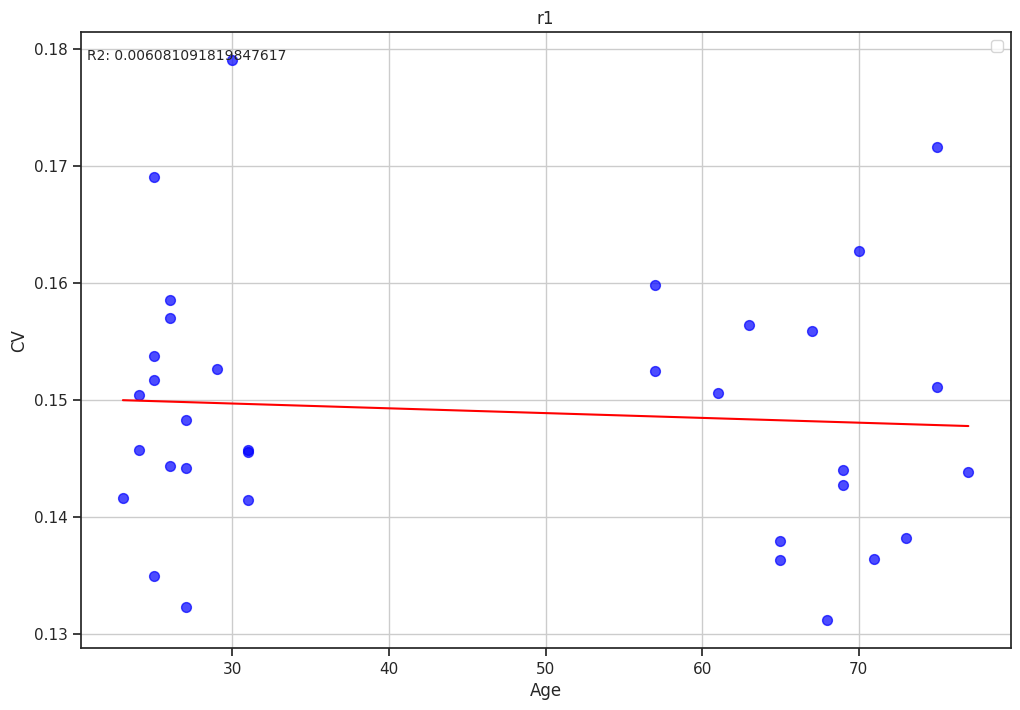

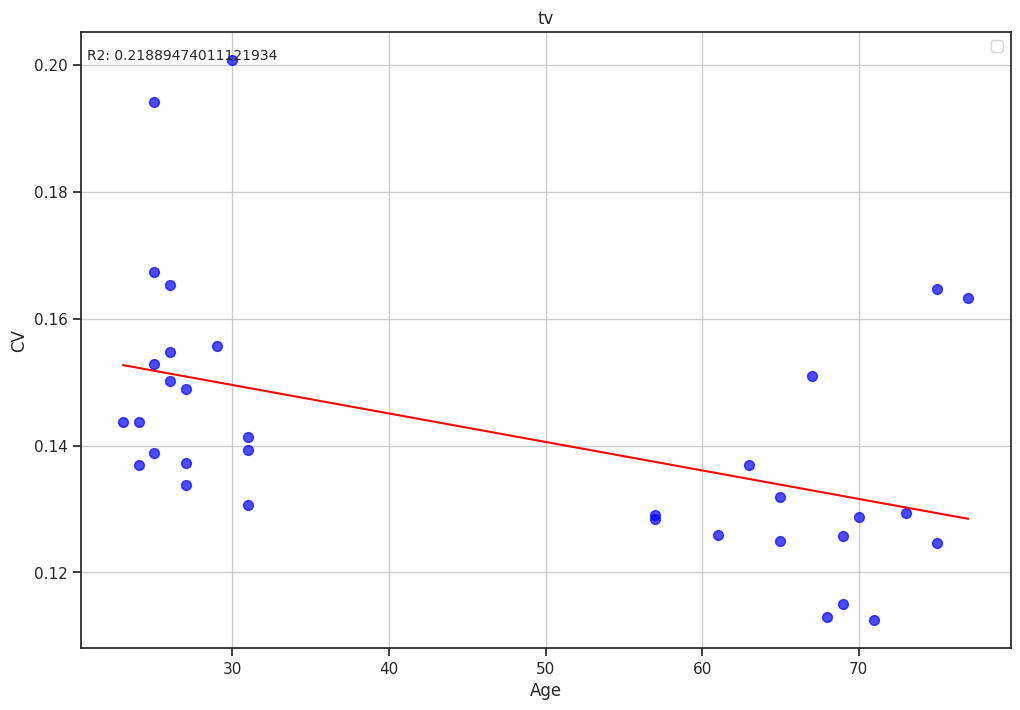

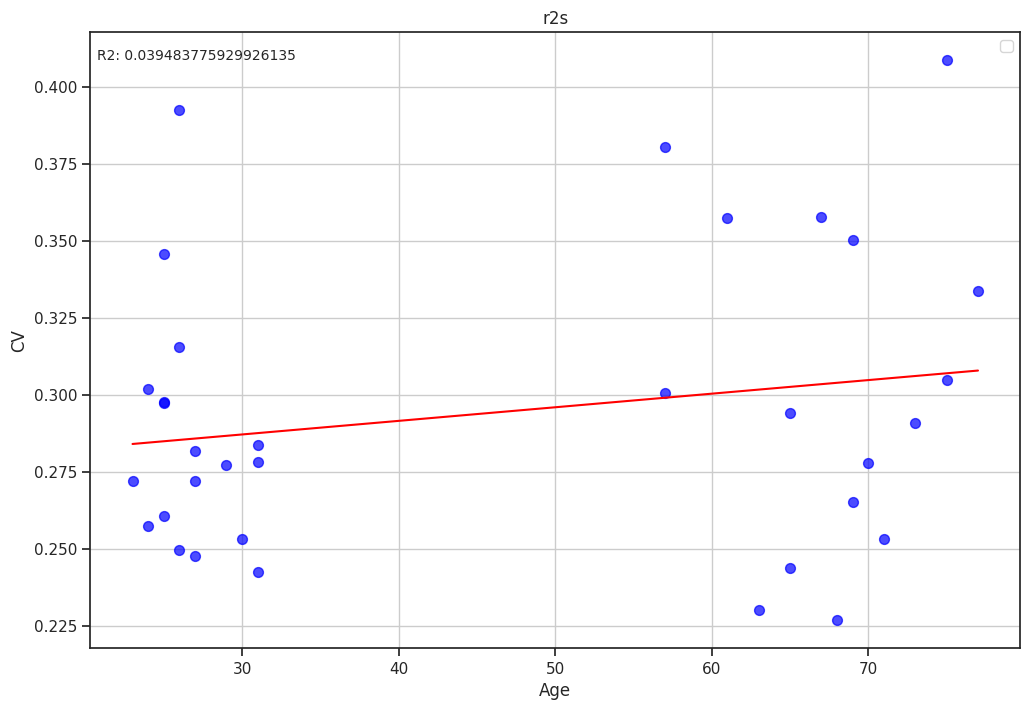

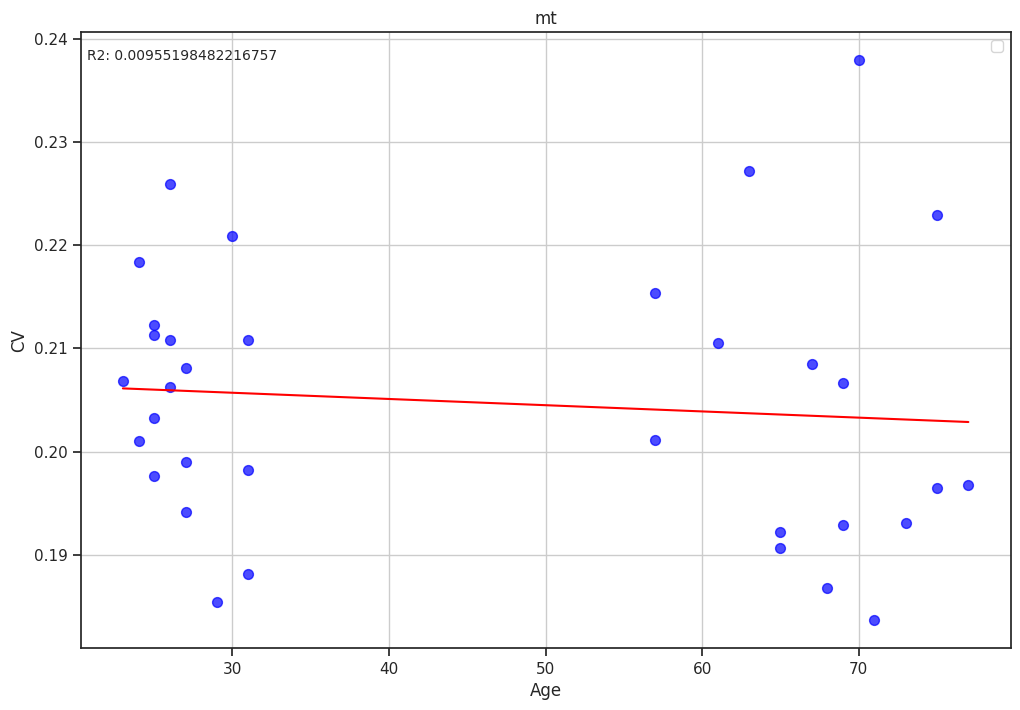

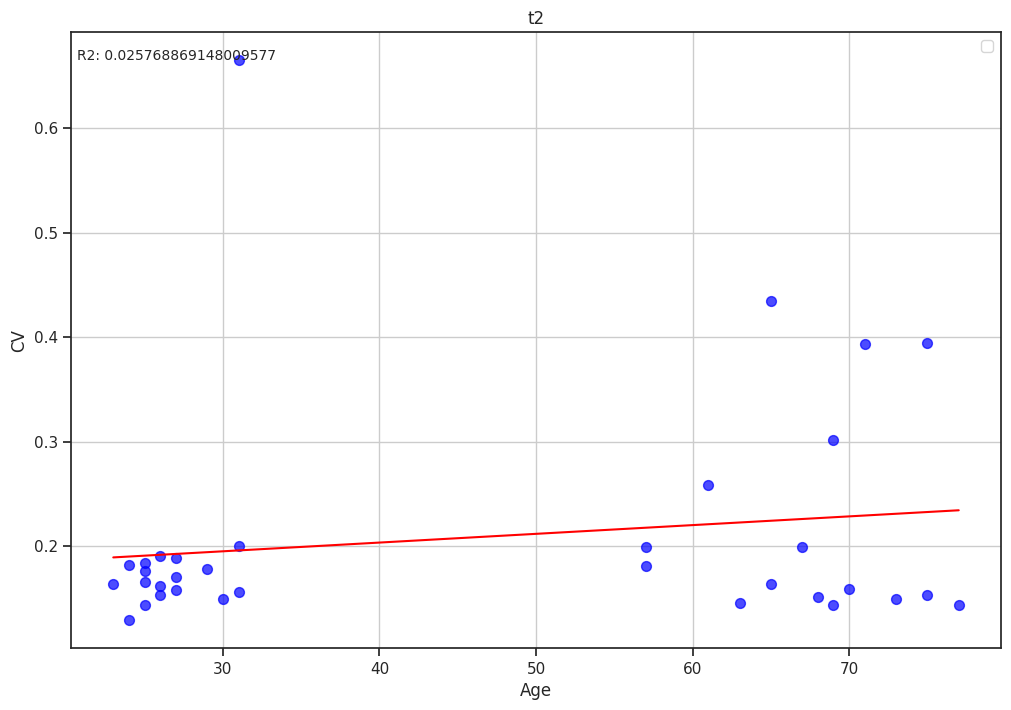

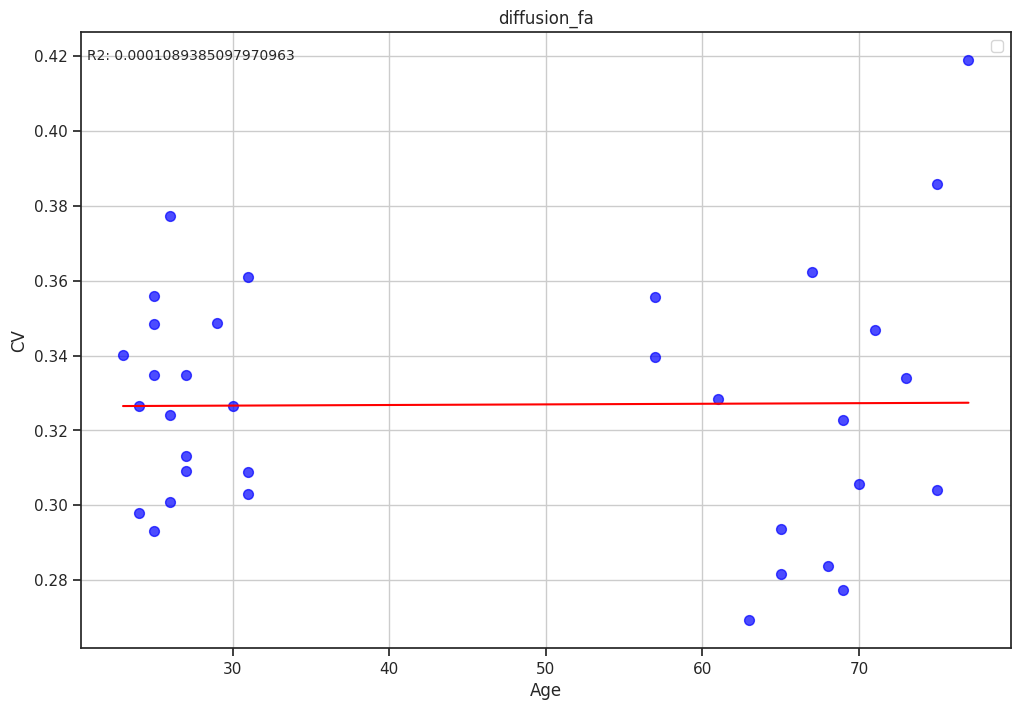

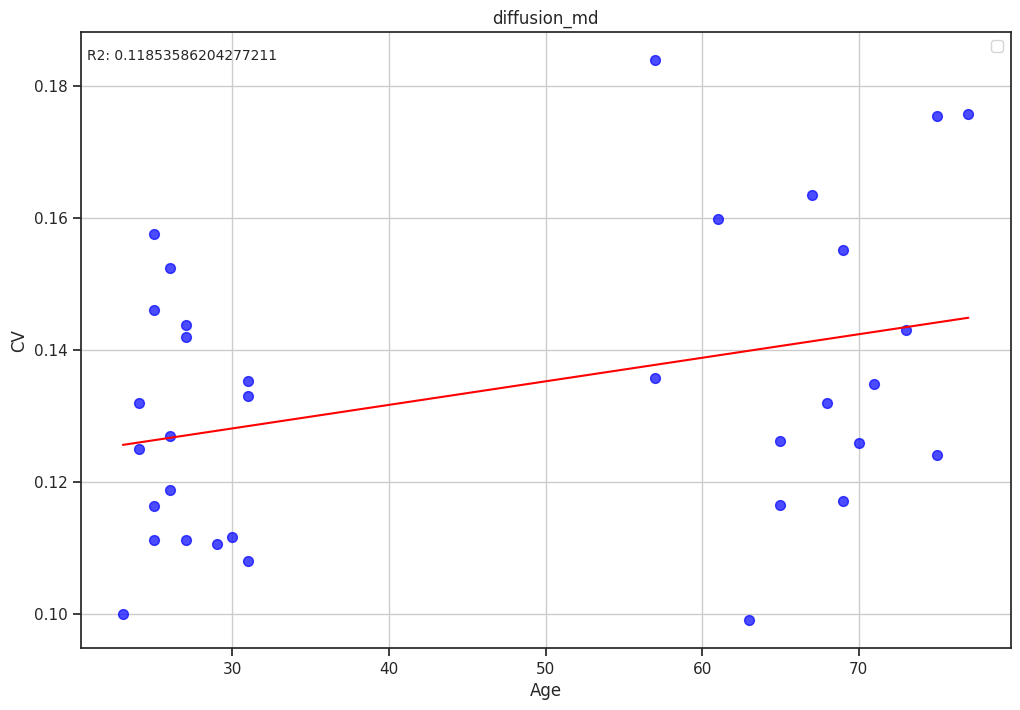

In [15]:
%autoreload 2
group_by_param = 'subjects'
x_axis = 'Age'
data_groups = [(chosen_data_raw, 'blue', '')]
StatisticsWrapper.calculate_cv_for_subjects(data_groups, group_by_param, params_to_work_with, x_axis, use_reg=True, fig_size=(12, 8))

F test to check if the age is significant 

In [16]:
%autoreload 2
group_by_param = 'subjects'
x_axis = 'Age'
StatisticsWrapper.calculate_cv_f_test(chosen_data_raw, group_by_param, params_to_work_with, x_axis)

Param r1 - Fail to reject the null hypothesis: No significant difference between simple_model and complex_model
Param tv - Fail to reject the null hypothesis: No significant difference between simple_model and complex_model
Param r2s - Fail to reject the null hypothesis: No significant difference between simple_model and complex_model
Param mt - Fail to reject the null hypothesis: No significant difference between simple_model and complex_model
Param t2 - Fail to reject the null hypothesis: No significant difference between simple_model and complex_model
Param diffusion_fa - Fail to reject the null hypothesis: No significant difference between simple_model and complex_model
Param diffusion_md - Fail to reject the null hypothesis: No significant difference between simple_model and complex_model


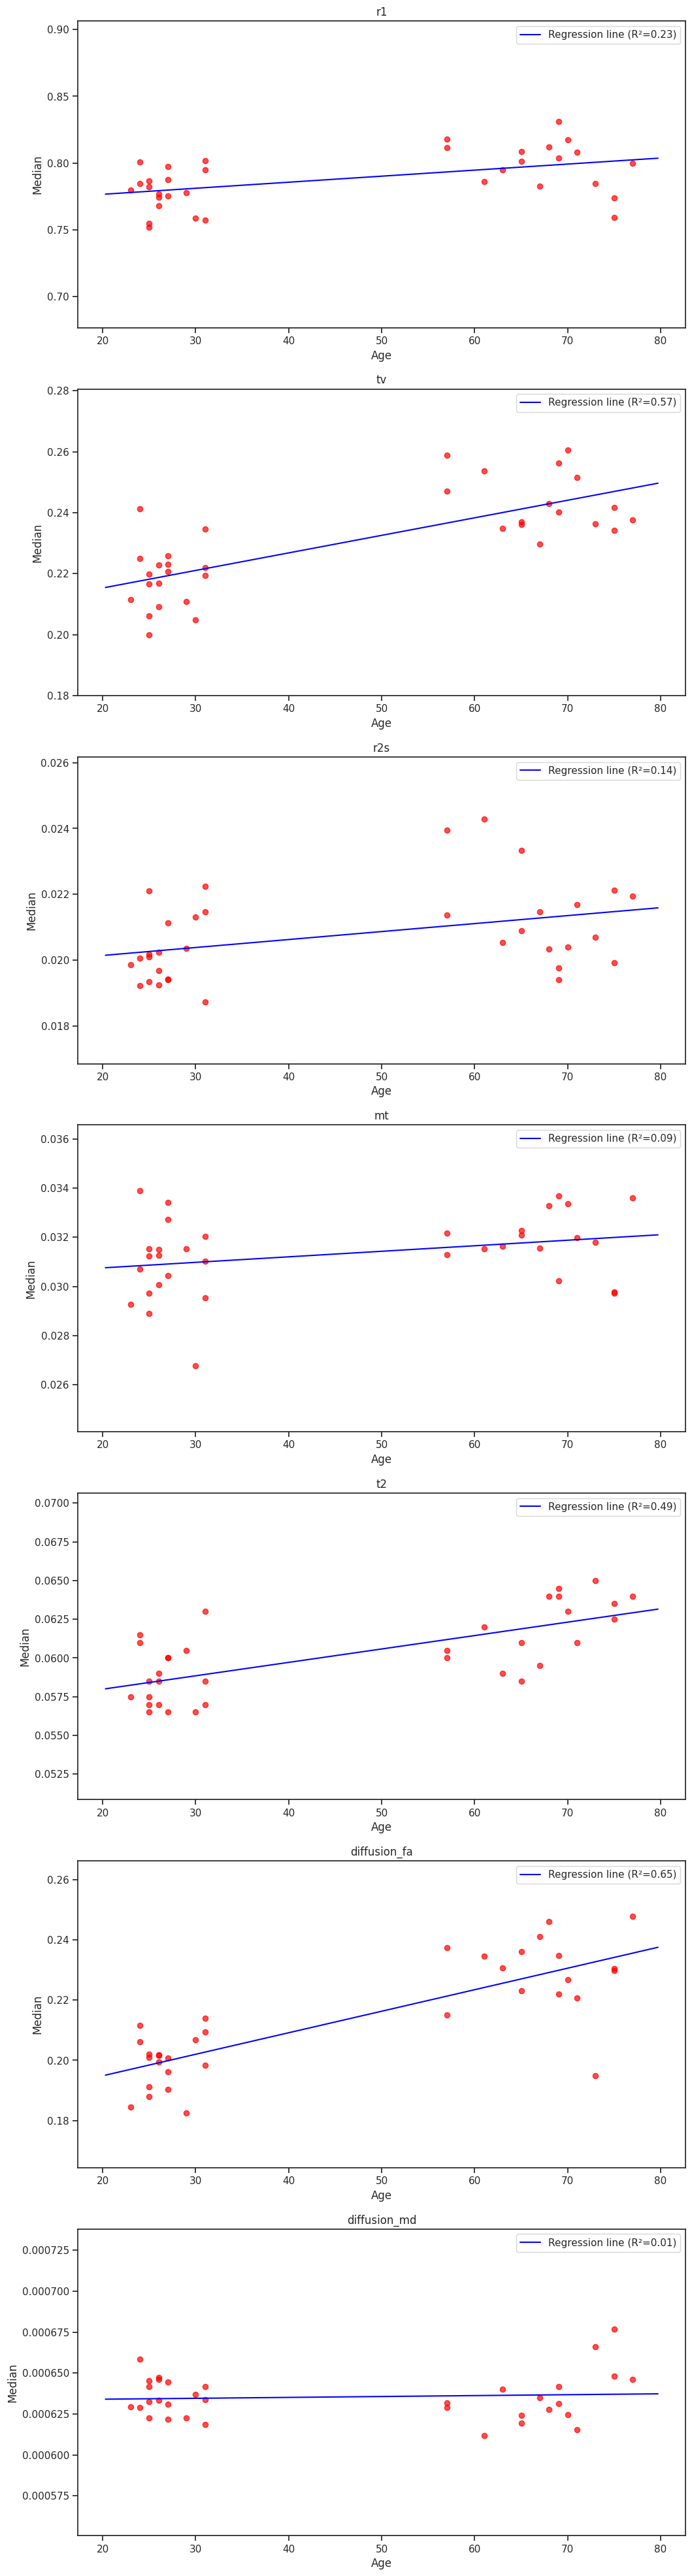

In [17]:
fig, ax = plt.subplots(nrows=len(params_to_work_with), ncols=1, figsize=(12, 50))

for i, param in  enumerate(params_to_work_with):
    medians = chosen_data_raw.groupby('subjects')[[param, 'Age']].median()
    ax[i].scatter(medians['Age'], medians[param], color='red', s=35, alpha=0.7)
    ax[i].set_title(f'{param}')
    ax[i].set_xlabel('Age')
    ax[i].set_ylabel('Median')
    lim = 0.1
    ax[i].set_ylim([min(medians[param]) - lim*min(medians[param]), max(medians[param]) + lim*min(medians[param])])


    # Calculate linear regression
    slope, intercept, r_value, p_value, std_err = linregress(medians['Age'], medians[param])
    x_values = np.array(ax[i].get_xlim())
    y_values = intercept + slope * x_values
    ax[i].plot(x_values, y_values, color='blue', label=f'Regression line (R²={r_value**2:.2f})')
    ax[i].legend()


## Check correlations on the normalized data

In [18]:
def show_correlations_stats(all_data, young_data, old_data, method):
    clusters_rois = StatisticsWrapper.hierarchical_clustering(all_data, params_to_work_with, 'single',
                                                                title="all")['dendrogram_data']['ivl']
    young_result = StatisticsWrapper.roi_correlations(young_data, params_to_work_with, clusters_rois,
                                                        group_title='Correlations of young group', method=method)
    old_result = StatisticsWrapper.roi_correlations(old_data, params_to_work_with, clusters_rois,
                                                     group_title='Correlations of old group', method=method)

    young_std_result = StatisticsWrapper.roi_correlations_std(young_data, params_to_work_with, clusters_rois,
                                                        title='Stds of Correlations of young group', method=method)
    old_std_result = StatisticsWrapper.roi_correlations_std(old_data, params_to_work_with, clusters_rois,
                                                             title='Stds of Correlations of old group', method=method)
                        
    PlotsManager.plot_heatmap(old_result - young_result, 'differences of old and young', project_name=None)
    young_corr_means, old_corr_means  = show_corr_mean(young_result, old_result, clusters_rois)

    # PlotsManager.plot_colors_on_brain(young_data.subjects.iloc[0], young_corr_means, chosen_rois_dict, 'young_corr', 'heat')
    # PlotsManager.plot_colors_on_brain(young_data.subjects.iloc[0], old_corr_means, chosen_rois_dict, 'old_corr', 'heat')

def show_corr_mean(young_result, old_result, clusters_rois):
    young_result['corr_mean'] = young_result.apply(np.mean, axis=1) - 1/young_result.shape[0]
    old_result['corr_mean'] = old_result.apply(np.mean, axis=1) - 1/old_result.shape[0]

    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('Average correlations')
    ax.scatter(clusters_rois, young_result['corr_mean'].to_numpy(), color='blue', s=20, alpha=0.7, label='young')
    ax.scatter(clusters_rois, old_result['corr_mean'].to_numpy(), color='red', s=20, alpha=0.7, label='old')

    # Connecting the points with vertical lines
    for x, y1, y2 in zip(clusters_rois, young_result['corr_mean'].to_numpy(), old_result['corr_mean'].to_numpy()):
        plt.plot([x, x], [y1, y2], color='gray', linestyle='--')
        
    ax.set_facecolor('white')
    ax.legend()

    return young_result['corr_mean'], old_result['corr_mean']


/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:532: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distances, method=linkage_metric)


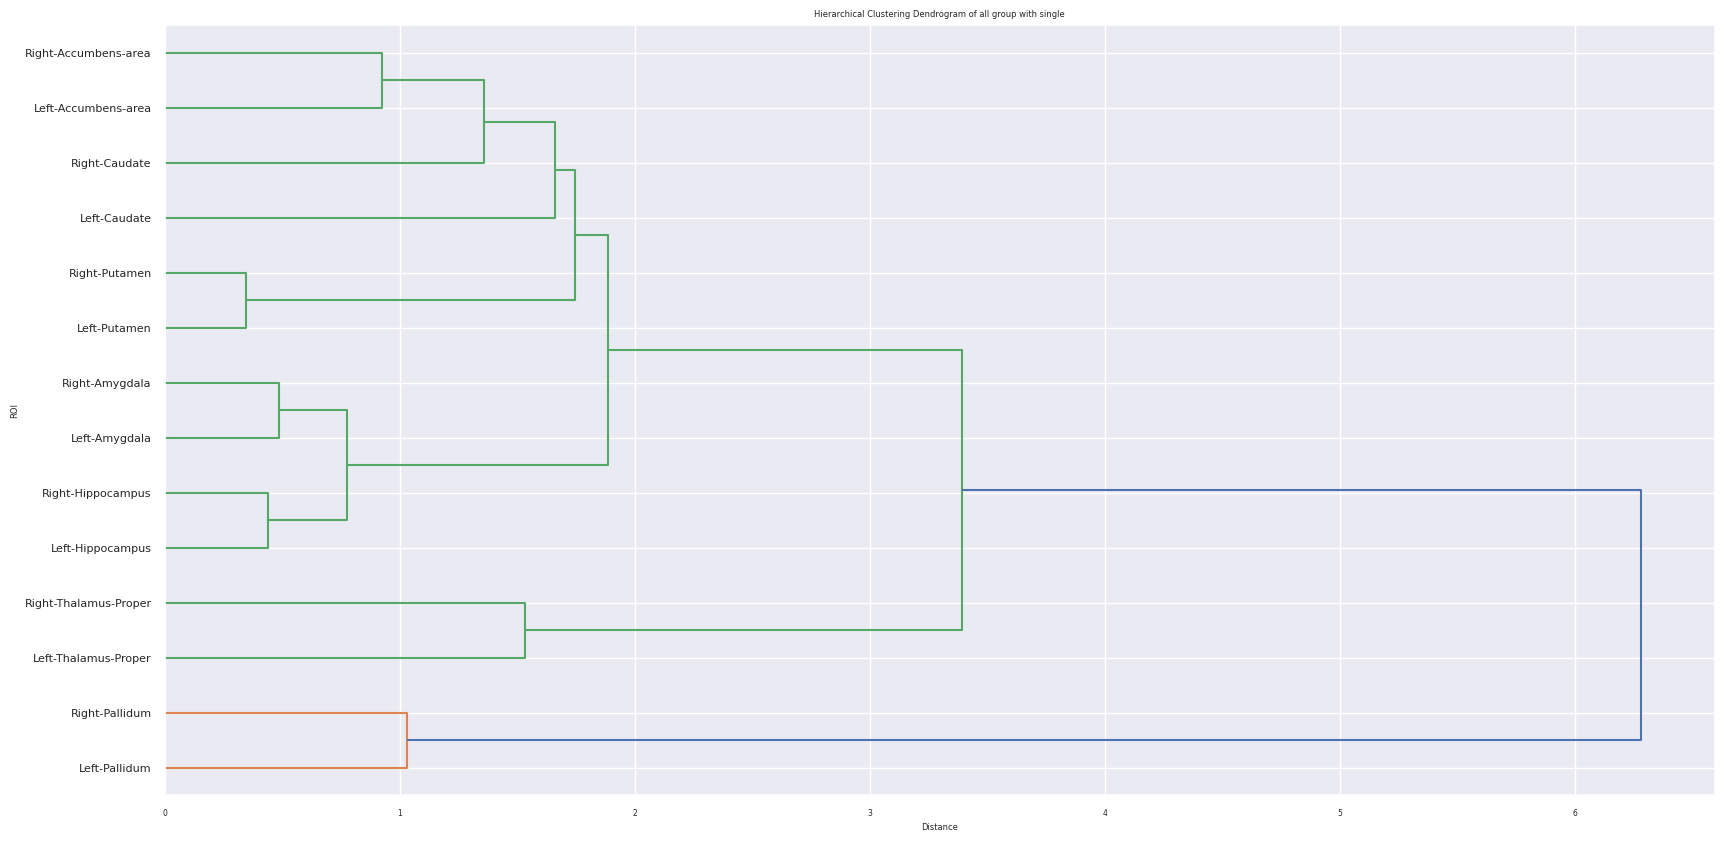

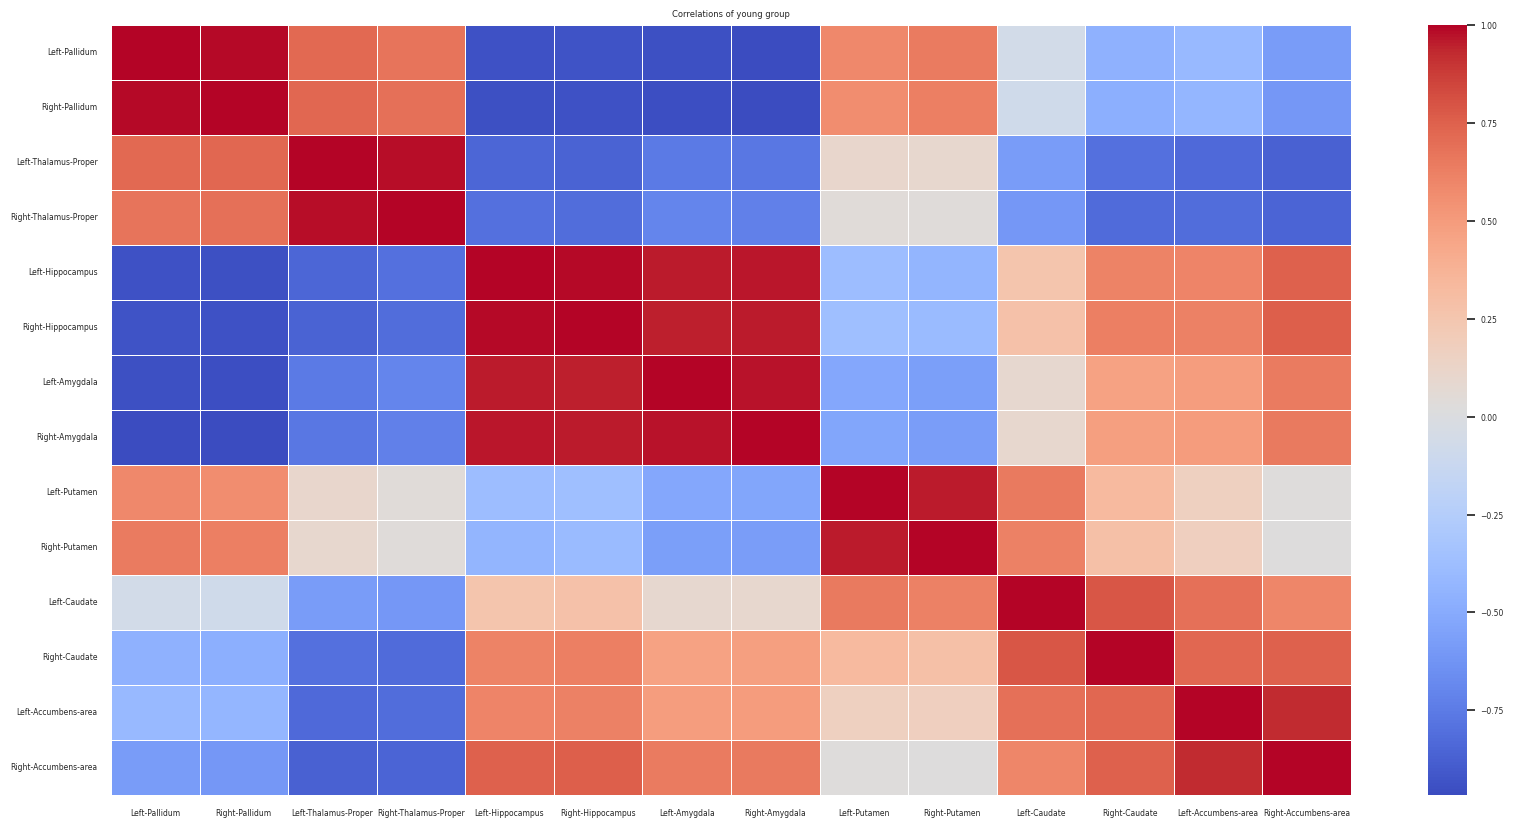

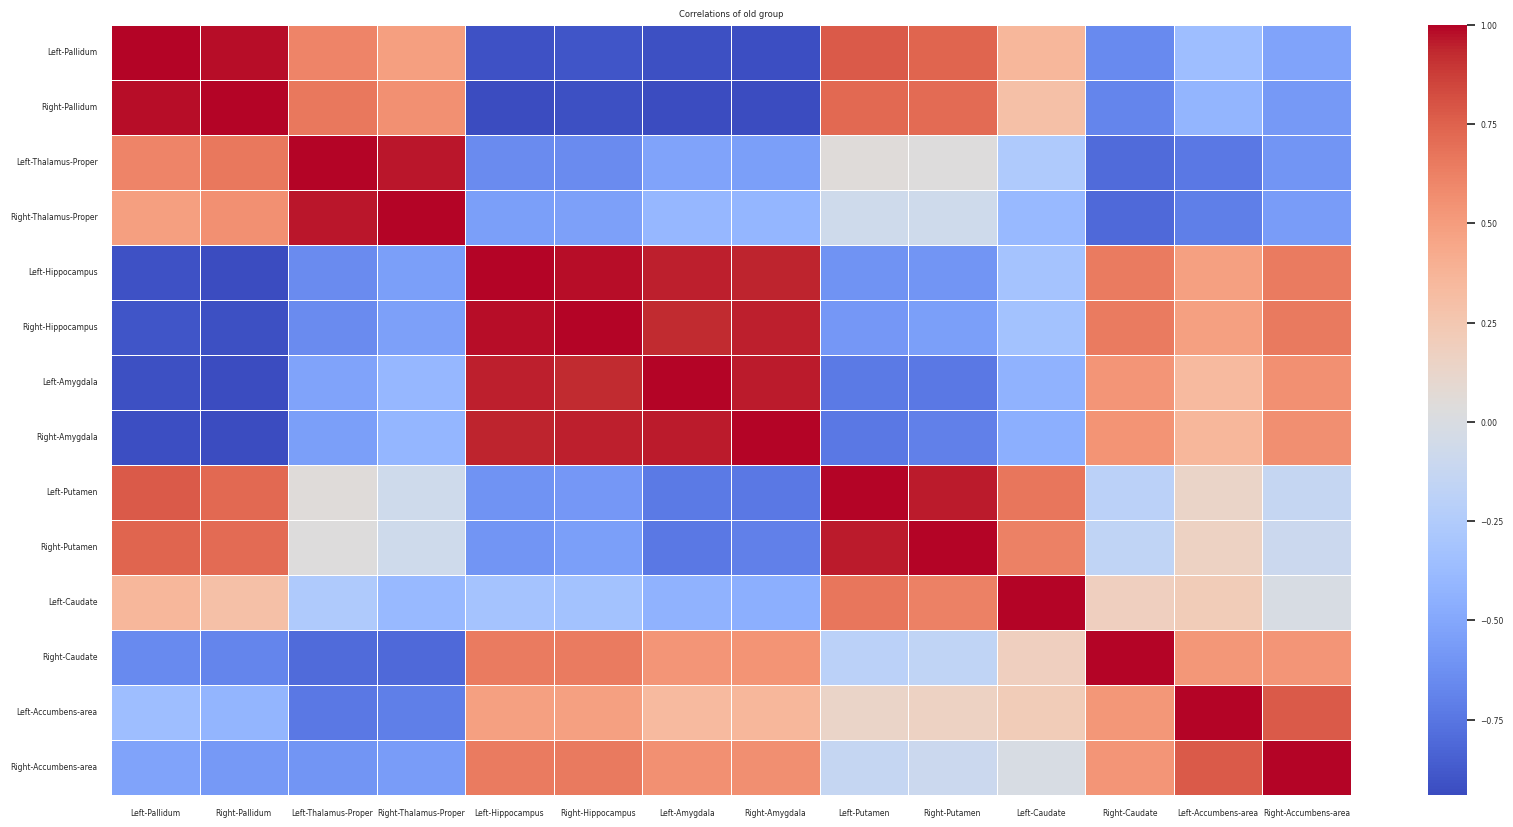

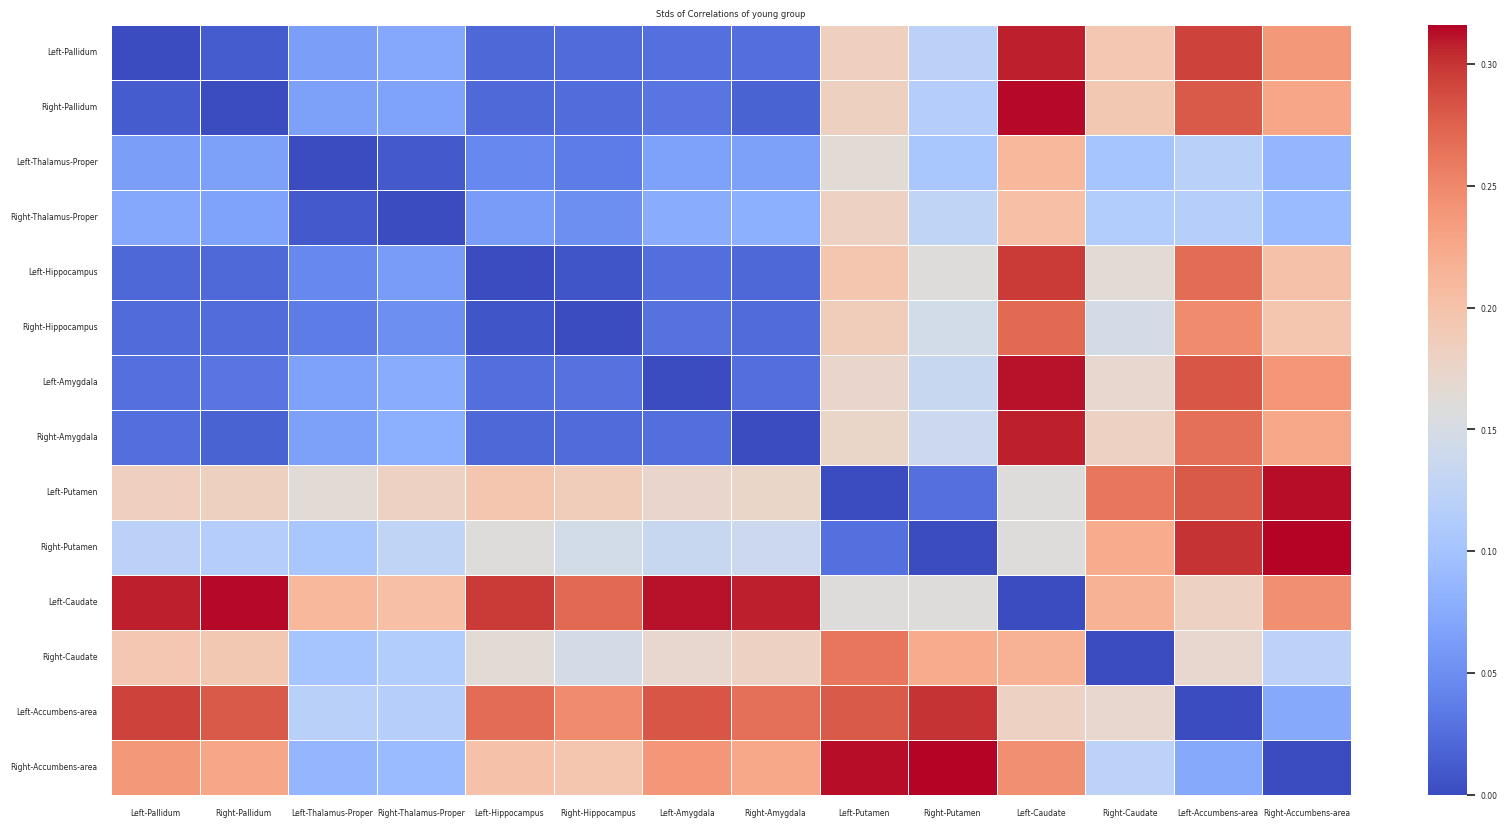

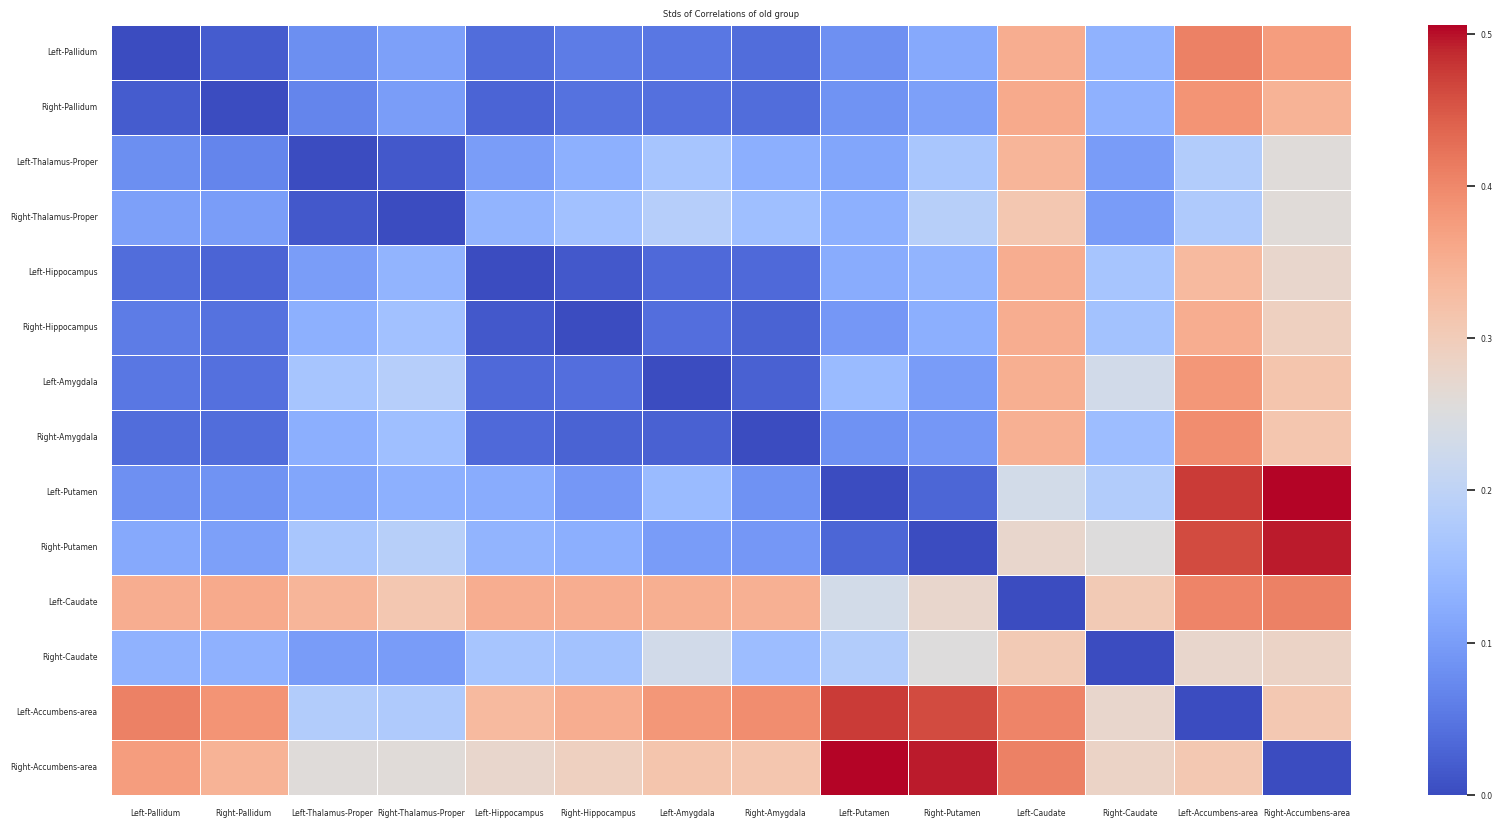

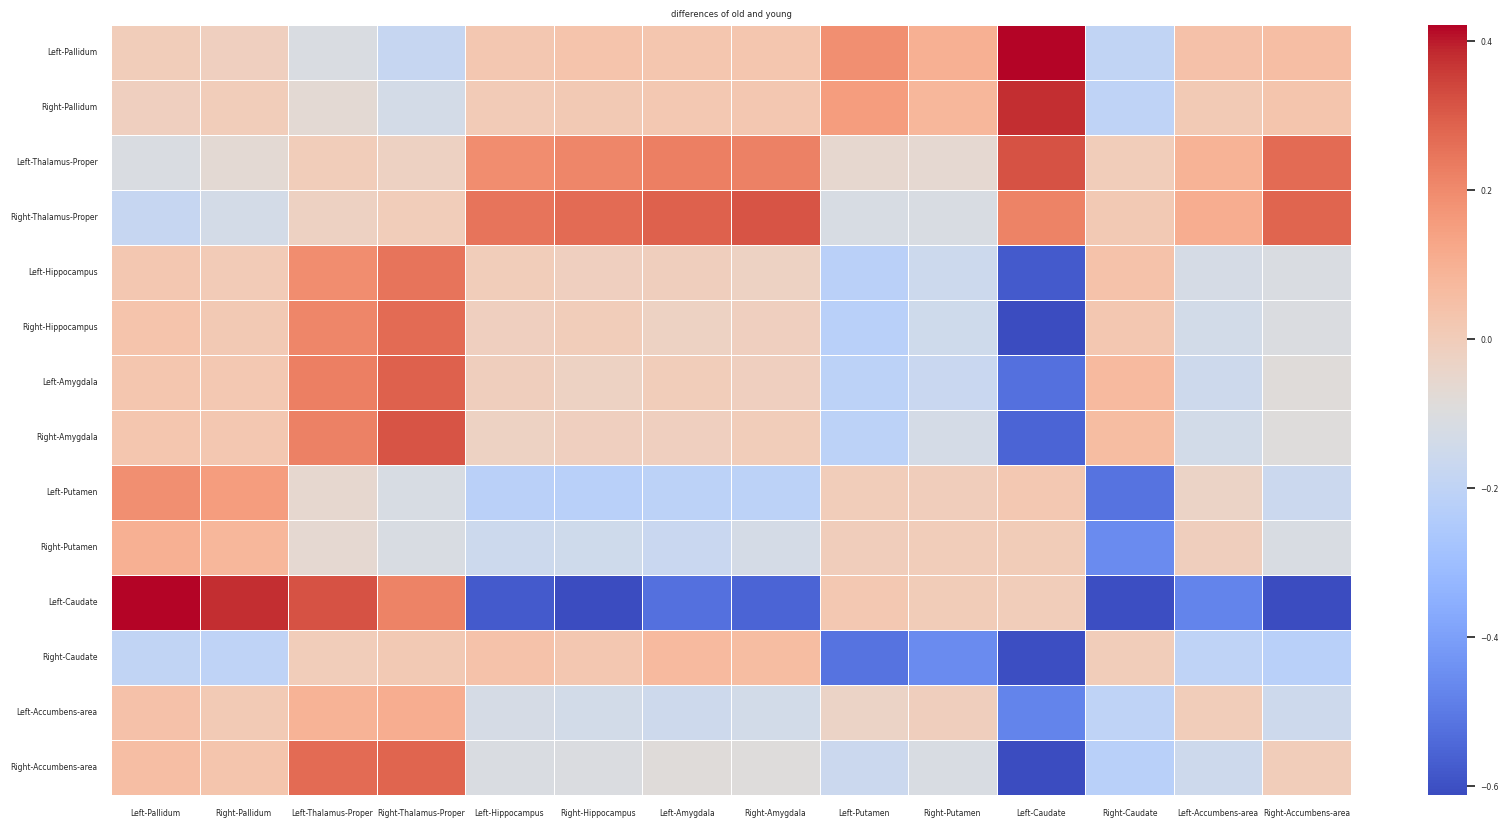

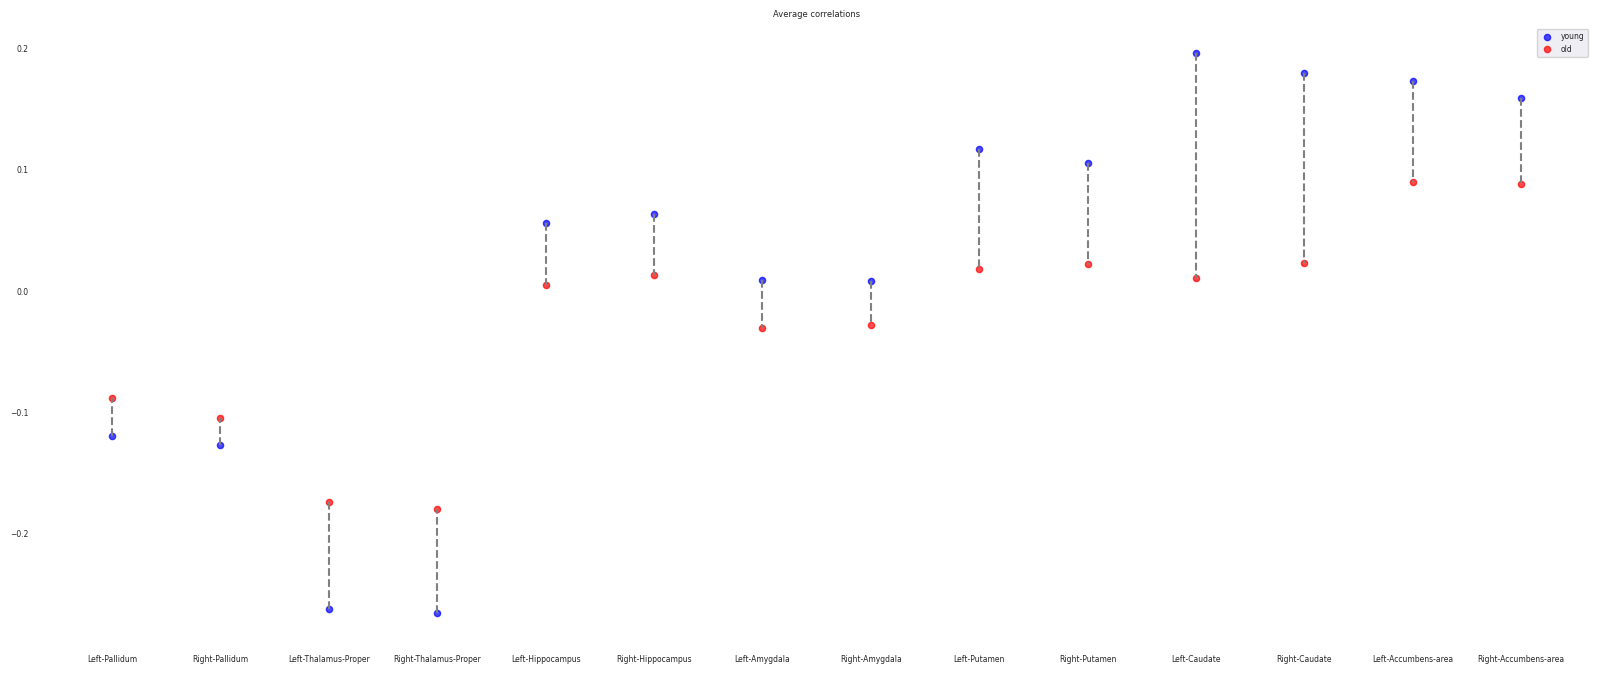

In [21]:
show_correlations_stats(chosen_data_z_score, young_subjects_z_score, old_subjects_z_score, 'pearson')

Check t_test on the young and old groups

In [22]:
StatisticsWrapper.t_test_per_parameter_per_area(young_subjects_z_score, old_subjects_z_score, chosen_rois_dict, 'ROI', params_to_work_with)

param r1 number of areas with significance differences: 9
param tv number of areas with significance differences: 5
param r2s number of areas with significance differences: 7
param mt number of areas with significance differences: 9
param t2 number of areas with significance differences: 10
param diffusion_fa number of areas with significance differences: 11
param diffusion_md number of areas with significance differences: 12


Subjects clustering 

In [23]:
def reduce_dim(model, data, drop_label=True):
    if drop_label:
        res = model.fit_transform(data.drop(columns='label'))
    else:
        res = model.fit(data.drop(columns='label'), data['label']).transform(data.drop(columns='label'))  

    column_names = [f"var_{i + 1}" for i in range(res.shape[1])]  # Generate dynamic column names
    reduced_data = pd.DataFrame(res, columns=column_names, index=data.index)

    reduced_data['label'] = data['label']
    # print(f'kl divergence: {model.kl_divergence_}')
    return reduced_data

In [24]:
young_features_df = pd.pivot_table(young_subjects_z_score, index='subjects', columns='ROI', values=params_to_work_with, aggfunc='sum')
old_features_df = pd.pivot_table(old_subjects_z_score, index='subjects', columns='ROI', values=params_to_work_with, aggfunc='sum')
data_features_df = pd.pivot_table(chosen_data_z_score, index='subjects', columns='ROI', values=params_to_work_with, aggfunc='sum')

young_mask = young_features_df.index
old_mask = old_features_df.index

# Assign labels directly to data_reduced_tsne DataFrame
data_features_df.loc[young_mask, 'label'] = 'young'
data_features_df.loc[old_mask, 'label'] = 'old'

In [25]:
dim = 0.95
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, perplexity=3, random_state=36)

data_reduced_pca = reduce_dim(pca, data_features_df, drop_label=True)
data_reduced_tsne = reduce_dim(tsne, data_features_df, drop_label=True)

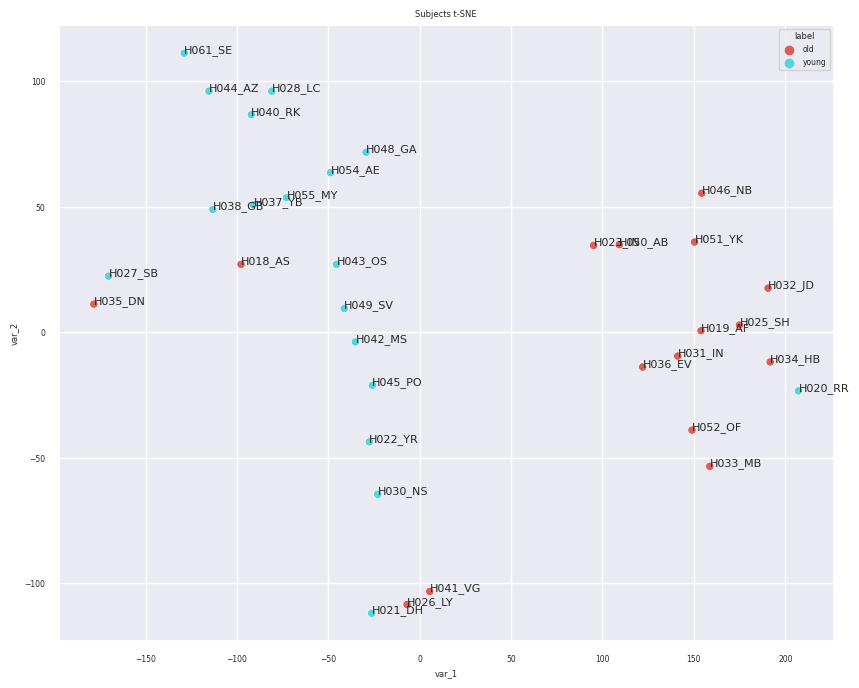

In [26]:
fig, ax = plt.subplots(figsize=(10,8))

sns.scatterplot(
    x="var_1", y="var_2",
    hue='label',
    palette=sns.color_palette("hls", 2),
    data=data_reduced_tsne,
    legend="full",
    ax=ax
    ).set_title('Subjects t-SNE')

for i, txt in enumerate(data_reduced_tsne.index):
    ax.annotate(txt, (data_reduced_tsne['var_1'][i], data_reduced_tsne['var_2'][i]), fontsize=8)
